# Feature Generation and Selection for Materials
## Case Study: Oxygen Ion Conducting Perovskite Oxides

In [846]:
# Load packages
import numpy as np
import pandas as pd
import os
import pymatgen as mg
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
import seaborn as sn
import copy
from functools import reduce

from citrination_client import CitrinationClient, PifSystemReturningQuery, DataQuery, DatasetQuery, Filter

from matminer.featurizers.composition import ElementProperty

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline 

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# TCO modules
from helpers.calc_chemfeat_2 import Perovskite, MatProjCalc
from helpers.featurizers import PerovskiteProperty
from helpers.feature_select import rank_correlation, get_linked_groups, xy_correlation_mag, choose_independent_features
import helpers.model_eval as mv

# misc custom modules
#from data_vis import xy_pairplots
from stats_misc import r_squared, binned_aggregate
from pickle_tools import save_pickle, load_pickle
from pdp_utils import pdp_iso_plot, model_iso_plots, ale_plot, model_ale_plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I. Load data

In [2]:
client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

In [3]:
# Get all pifs from dataset
ds_id = '176703'
# Hayashi, H., Inaba, H., Matsuyama, M., Lan, N. G., Dokiya, M., & Tagawa, H. (1999). Structural consideration on the ionic conductivity of perovskite-type oxides. Solid State Ionics, 122(1–4), 1–15. https://doi.org/10.1016/S0167-2738(99)00066-1

query = PifSystemReturningQuery(
            query=DataQuery(
                dataset=DatasetQuery(
                    id=Filter(equal=ds_id)
                )
            )
        )

results = client.search.pif_search(query)
formulas = [hit.system.chemical_formula for hit in results.hits]
conductivities = [float(hit.as_dictionary()['system']['properties'][0]['scalars'][0]['value']) for hit in results.hits]

# Convert to compositions. Store unreadable formulas for inspection later
def is_bad_formula(formula):
    try:
        mg.Composition(formula)
        return False
    except mg.core.composition.CompositionError:
        return True


compositions = [mg.Composition(f) for f in formulas if is_bad_formula(f)==False]
bad_formulas = [f for f in formulas if is_bad_formula(f)]

Citrination Client Warning - Query size greater than max system size - only 10000 results will be returned


In [673]:
# check unreadable formulas
bad_formulas

['SrSc0.5Al0 45Y0 05Al0 5 . . .O2.5',
 'BaGd0.5In0 3Ga0.2Al0 5 . . O',
 'BaGd0.5In0 4Ga0.1Al0 5 . . O',
 'BaIn0.8Ca0.1Zr0.1Al0.5 O2 5']

# II. Data validation/analysis

Before beginning any featurization or modeling, we need to examine the dataset to understand some basic details about the materials included:
* What are the possible cation oxidation states? Are there any multivalent cations?
* Do the compositions fit the ABX3 perovskite formula?
* Are the compositions charge balanced?
* Are there site deficiencies at the A and/or B sites?
* Which elements are at each site? Do any elements appear at multiple sites?
* What is the distribution of conductivity values?

### Cation oxidation states

In [5]:
# Check for multivalent cations
unique_elements = np.unique(sum([c.elements for c in compositions],[]))
multivalent_elements = unique_elements[np.where(np.array([len(el.common_oxidation_states) for el in unique_elements]) > 1)]
dict(zip(multivalent_elements,[el.common_oxidation_states for el in multivalent_elements]))

{Element Si: (-4, 4)}

The only metal with multiple common oxidation states is Si, which may exhibit a 4- charge. However, since the metals will always be cationic in these oxides, we can ignore the negative oxidation state.

In [6]:
# get oxidation state of each cation in dataset for reference
def cation_ox_state(el):
    "only positive oxidation states"
    pos_states = [ox for ox in el.common_oxidation_states if ox > 0]
    if len(pos_states)==1:
        return pos_states[0]
    elif len(pos_states) > 1:
        raise ValueError('Multiple positive oxidation states')
    elif len(pos_states)==0:
        raise ValueError('No positive oxidation states')

cation_ox_states = dict(zip(unique_elements,[cation_ox_state(el) for el in unique_elements if el.name!='O']))
cation_ox_states

{Element Ba: 2,
 Element Sr: 2,
 Element Ca: 2,
 Element La: 3,
 Element Yb: 3,
 Element Nd: 3,
 Element Sm: 3,
 Element Gd: 3,
 Element Y: 3,
 Element Lu: 3,
 Element Mg: 2,
 Element Zr: 4,
 Element Sc: 3,
 Element Ti: 4,
 Element Be: 2,
 Element Al: 3,
 Element Zn: 2,
 Element In: 3,
 Element Ga: 3,
 Element Si: 4,
 Element Ni: 2}

### Perovskite vs. Non-Perovskite Formulas

Text(0.5, 1.0, 'Total Cation Units')

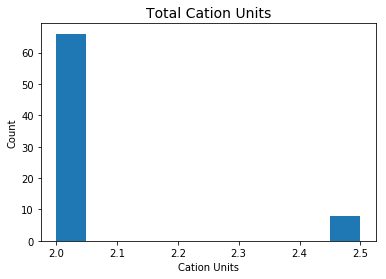

In [675]:
# Check total number of cation atoms
cation_amt = np.array([round(c.num_atoms - c.get('O'),4) for c in compositions])
plt.hist(cation_amt)
plt.xlabel('Cation Units')
plt.ylabel('Count')
plt.title('Total Cation Units',size=14)

A small number of compositions in the dataset have 2.5 total cation units.These are non-perovskite structures and will thus be excluded from this analysis.

In [8]:
#filter to compositions with 2 cation units
good_cation_compositions = np.array([c for c in compositions if round(c.num_atoms - c.get('O'),4)==2])

### Charge Balance

Text(0.5, 1.0, 'Net Charge')

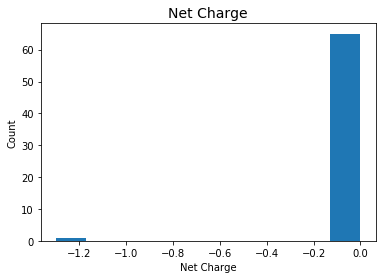

In [676]:
# check net charge
def oxide_net_charge(comp):
    cation_charge = sum([comp[el]*cation_ox_state(el) for el in comp.elements if el.name!='O'])
    return cation_charge - 2*comp['O']

net_charge = np.round([oxide_net_charge(c) for c in good_cation_compositions],4)
comp_charge = dict(zip(good_cation_compositions,net_charge))

plt.hist(net_charge)
plt.xlabel('Net Charge')
plt.ylabel('Count')
plt.title('Net Charge',size=14)

In [711]:
# check charge unbalanced compositions
dict(zip(good_cation_compositions[np.where(net_charge!=0)],net_charge[np.where(net_charge!=0)]))

{Comp: Sr1 Mg0.1 Sc0.5 Al0.4 O2.475: -0.05, Comp: Ba1 Zr0.3 In0.7 O3.3: -1.3}

In [722]:
# examine second charge unbalanced composition
def try_comp(formula):
    try:
        comp = mg.Composition(formula)
    except mg.core.composition.CompositionError:
        comp = ''
    return comp

all_comps = [try_comp(f) for f in formulas]
idx = all_comps.index(mg.Composition('Ba1 Zr0.3 In0.7 O3.3'))
formulas[idx]

'BaZr0.3In0.7O0.65O2.65'

There are 2 compositions that are not charge-balanced. The first is very nearly charge balanced and may simply be off due to rounding of atomic fractions, while the second is far from being charge neutral. Upon examination, the second formula is BaZr$_{0.3}$In$_{0.7}$O$_{0.65}$O$_{2.65}$, which should be corrected to BaZr$_{0.3}$In$_{0.7}$O$_{2.65}$. With this correction, both compositions are kept in the dataset.

In [727]:
# Fix unbalanced composition and re-check charge balance
formulas[idx] = 'BaZr0.3In0.7O2.65'
compositions = [mg.Composition(f) for f in formulas if is_bad_formula(f)==False]
net_charge = np.round([oxide_net_charge(c) for c in good_cation_compositions],4)
comp_charge = dict(zip(good_cation_compositions,net_charge))
good_cation_compositions = np.array([c for c in compositions if round(c.num_atoms - c.get('O'),4)==2])
dict(zip(good_cation_compositions[np.where(net_charge!=0)],net_charge[np.where(net_charge!=0)]))

{Comp: Sr1 Mg0.1 Sc0.5 Al0.4 O2.475: -0.05}

It's also helpful to know the distribution of A and B site oxidation states and total cation charge in these compositions. These tell us about the typical oxidation state for each site, the level of aliovalent cation doping, and the degree of oxygen non-stoichiometry in these compounds. The `Perovskite` class easily provides this information.

Text(0.5, 1.0, 'Cation Site Oxidation State Distribution')

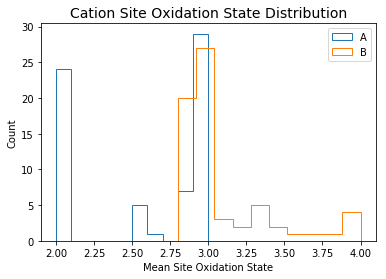

In [730]:
# look at A-site and B-site oxidation states
A_site_ox = np.empty(len(good_cation_compositions))
B_site_ox = np.empty(len(good_cation_compositions))
A_site_sum = np.empty(len(good_cation_compositions))
B_site_sum = np.empty(len(good_cation_compositions))

for i,comp in enumerate(good_cation_compositions):
    p = Perovskite.from_ordered_formula(comp.formula)
    A_site_ox[i] = p.site_mean_func('A',cation_ox_state)
    B_site_ox[i] = p.site_mean_func('B',cation_ox_state)
    A_site_sum[i] = p.site_sum('A')
    B_site_sum[i] = p.site_sum('B')

fig, ax = plt.subplots()
ax.hist(A_site_ox,histtype='step',label='A')
ax.hist(B_site_ox,histtype='step',label='B')
ax.legend()
ax.set_xlabel('Mean Site Oxidation State')
ax.set_ylabel('Count')
ax.set_title('Cation Site Oxidation State Distribution',size=14)

The A site cations tend to have lower oxidation states than the B site cations, which is to be expected given the larger size of the A site in the perovskite structure. However, about half of the compounds appear to have nearly equal A and B site oxidation states.

Text(0, 0.5, 'Count')

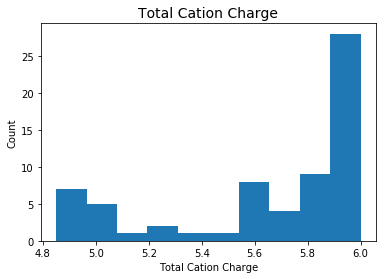

In [731]:
# total cation charge
plt.hist(A_site_ox+B_site_ox)
plt.title('Total Cation Charge',size=14)
plt.xlabel('Total Cation Charge')
plt.ylabel('Count')

The total cation charge ranges from ~4.8 to 6, corresponding to oxygen non-stoichiometries ($\delta$ values) as high as 0.6 and as low as zero. Most compositions have relatively small oxygen non-stoichiometries.

### Site Occupancy and Deficiency

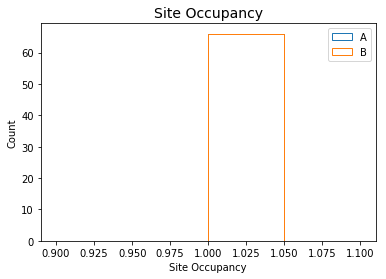

In [732]:
# site occupancies
bins = np.arange(0.9,1.101,0.05)
fig, ax = plt.subplots()
ax.hist(np.round(A_site_sum,5),bins=bins,histtype='step',label='A')
ax.hist(B_site_sum,bins=bins,histtype='step',label='B')
ax.set_xlabel('Site Occupancy')
ax.set_ylabel('Count')
ax.set_title('Site Occupancy',size=14)
ax.legend()

All of the considered compositions are stoichiometric (fully occupied, with no deficiency or surplus) at the A and B sites.

### Element Site Assignments

With some basic checks on composition complete, we can now limit our analysis to the compositions that we wish to consider in our model, and take a closer look at the chemical makeup of each site.

In [19]:
# set up filter to define which formulas are used in the model
def formula_filter(formula):
    "Exclude non-perovskite formuals and unreadable formulas"
    try:
        comp = mg.Composition(formula)
        # check for 2 total cation units
        if round(comp.num_atoms - comp.get('O'),4)==2:
            return True
        else:
            return False
    except mg.core.composition.CompositionError:
        return False
    
model_records = [(f,c) for f,c in zip(formulas,conductivities) if formula_filter(f)]
model_formulas = [f for f,c in model_records]

In [735]:
# Check A and B site elements
csites = [Perovskite.from_ordered_formula(f).cation_site for f in model_formulas]
A_site_elements = np.unique(sum([[k for k,v in cs.items() if v=='A'] for cs in csites],[]))
B_site_elements = np.unique(sum([[k for k,v in cs.items() if v=='B'] for cs in csites],[]))
print('A site elements:', A_site_elements)
print('B site elements:', B_site_elements)
# Elements appearing at both A and B sites in different compositions
print('Elements at both sites:', list(np.intersect1d(A_site_elements,B_site_elements)))

A site elements: ['Ba' 'Ca' 'Gd' 'La' 'Nd' 'Sm' 'Sr' 'Y' 'Yb']
B site elements: ['Al' 'Be' 'Ca' 'Ga' 'In' 'Lu' 'Mg' 'Ni' 'Sc' 'Si' 'Ti' 'Y' 'Zn' 'Zr']
Elements at both sites: ['Ca', 'Y']


Generally, alkaline earth metals and lanthanides occupy the A site, while a range of elements from groups across the periodic table appear at the B site. Ca and Y are the only metals that appear at both sites.

Many of the elements that appear at each site appear in small amounts as dopants. To get a better sense of the primary constituents at each site, we can look at the major elements at each site - elements that comprise an atomic fraction of at least 0.5 at that site.

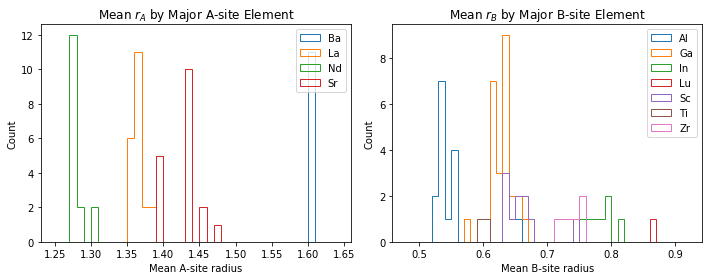

In [1082]:
# get major A and B site elements
perovs = [Perovskite.from_ordered_formula(f) for f in pk_df['formula']]
major_A_site_elements = [[k.name for k,v in p.site_composition['A'].items() if v>=0.5] for p in perovs]
major_A_site_elements_unique = np.unique(sum(major_A_site_elements,[]))

major_B_site_elements = [[k.name for k,v in p.site_composition['B'].items() if v>=0.5] for p in perovs]
major_B_site_elements_unique = np.unique(sum(major_B_site_elements,[]))

# create list of compositions for each major A-site element
A_site_idx = {}
for el in major_A_site_elements_unique:
    idx = []
    for i,entry in enumerate(major_A_site_elements):
        if el in entry:
            idx.append(i)
    A_site_idx[el] = idx
    
B_site_idx = {}
for el in major_B_site_elements_unique:
    idx = []
    for i,entry in enumerate(major_B_site_elements):
        if el in entry:
            idx.append(i)
    B_site_idx[el] = idx
    
# plot radius distributions by major element
fig, axes = plt.subplots(1,2,figsize=(10,4))

for el, idx in A_site_idx.items():
    r_mean = pk_df.iloc[idx,:]['Asite_oxmean_r_mean']
    axes[0].hist(r_mean,bins=np.arange(1.25,1.65,0.01),label=el,histtype='step')
    
for el, idx in B_site_idx.items():
    r_mean = pk_df.iloc[idx,:]['Bsite_oxmean_r_mean']
    axes[1].hist(r_mean,bins=np.arange(0.48,0.92,0.01),label=el,histtype='step')
    
axes[0].legend()
axes[0].set_title('Mean $r_A$ by Major A-site Element')
axes[0].set_xlabel('Mean A-site radius')
axes[0].set_ylabel('Count')

axes[1].legend()
axes[1].set_title('Mean $r_B$ by Major B-site Element')
axes[1].set_xlabel('Mean B-site radius')
axes[1].set_ylabel('Count')

fig.tight_layout()

There are four metals that appear as major elements at the A site: Ba, La, Nd, and Sr. Compositions with different primary A site elements are fairly well separated by the mean A site radius. In contrast, a larger number of elements appear as primary elements at the B site, and these are less clearly separated by mean B site radius, indicating the greater degree of doping at the B site.

### Conductivity Distribution

Finally, we should examine the distribution of conductivity values for the compositions that we wish to consider in our model.

Text(0.5, 1.0, 'Conductivity Distribution')

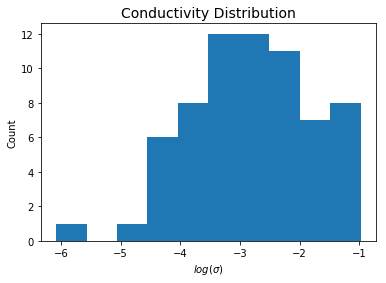

In [747]:
plt.hist([c for (f,c) in model_records])
plt.xlabel('$log(\sigma)$')
plt.ylabel('Count')
plt.title('Conductivity Distribution',size=14)

The log conductivity values are reasonably close to normally distributed considering the fairly small dataset size, with the center around -3.

# III. Featurize compositions

With initial validation complete, we have verified basic data integrity and defined our modeling dataset. The next step is to generate features that will be used to construct machine learning models. What defines a good feature or feature set? Any feature set should meet some basic conditions:
* Readily calculable from available data
* Uniquely describe different compositions
* Quantitative

Beyond these basic requirements, we may also want to consider some more nuanced qualities of feature sets:
* Interpretability and physical meaning
* Generalizability/extensibility to compositions outside the training set

These considerations depend heavily on the materials set and materials properties of interest. In this case study of oxide conductivity in perovksite oxides, we will consider three distinct feature libraries:
* Naive featurization using atomic fractions only ("Naive")
* MAGPIE, a common and highly general materials feature library ("Magpie")
* A custom perovskite library, developed for analysis of triple conducting perovskite cathodes ("Perovskite")

The custom perovskite library includes a number of features that overlap with MAGPIE, so we will also consider a fourth feature set that includes only the core, custom features of the perovskite library ("Perovskite Core"). 

ALl of these feature sets obey the basic requirements outlined above. Howver, they differ in interpretability and physical relevance to the property of interest. We will test the utility of each feature set for modeling this dataset, and compare the performance and interpretability of the resulting models. Each feature set is generated below.

In [22]:
# dfs to feed various featurizers
df = pd.DataFrame(model_records,columns=['formula','log_sigma'])
cdf = pd.DataFrame([(mg.Composition(r[0]),r[1]) for r in model_records],columns=['composition','log_sigma'])

In [593]:
# naive featurization - element fraction vector
all_el = np.unique(sum(cdf['composition'].map(lambda x: [e.name for e in x.elements]),[]))
el_vector = lambda comp: np.array([comp.get(el)/comp.num_atoms for el in all_el])
ev_list = list(cdf['composition'].map(el_vector).values)
nv_df = pd.concat([cdf,pd.DataFrame(ev_list,columns=[f'{el}_frac' for el in all_el])],axis=1)

In [23]:
# magpie library
ep = ElementProperty.from_preset('magpie')
ep_df = ep.featurize_dataframe(cdf,col_id='composition',inplace=False)

HBox(children=(IntProgress(value=0, description='ElementProperty', max=66, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [24]:
# perovksite feature library
pp = PerovskiteProperty.ordered_formula_featurizer(site_base_ox={'A':2.5,'B':3.5,'X':-2})
pp.set_featurize_options(sites=['A','B','comp'],ox_stats=['mean'],silent=False)
pk_df = pp.featurize_dataframe(df,col_id='formula',inplace=False)

HBox(children=(IntProgress(value=0, description='PerovskiteProperty', max=66, style=ProgressStyle(description_width='initial')), HTML(value='')))

To robustly assess model performance, we will split the dataset into training and validation ("holdout") sets. The training set will be used for feature selection and hyperparameter optimization. The optimized models will then be used to predict the holdout, which is the true test of performance. Below we randomly select 80% of the samples for the training set, and leave the remaining 20% for the holdout. A single random state is specified to ensure that the same compositions are assigned to training and validation sets for all four feature sets.

In [893]:
# Naive data matrix
nv_X = nv_df.drop(['composition','log_sigma'],axis=1)
nv_Xy = nv_df.loc[:,list(nv_X.columns) + ['log_sigma']]

# Magpie data matrix
nan_cols = list(ep_df.columns[pd.isnull(ep_df).max()])
ep_X = ep_df.drop(['composition','log_sigma'] + nan_cols,axis=1)
ep_Xy = ep_df.loc[:,list(ep_X.columns) + ['log_sigma']]

# perovskite data matrix
nan_cols = list(pk_df.columns[pd.isnull(pk_df).max()])
pk_X = pk_df.drop(['formula','log_sigma'] + nan_cols,axis=1)
pk_Xy = pk_df.loc[:,list(pk_X.columns) + ['log_sigma']]

# remove extraneous features to get core feature set
feature_category = dict(zip(pp.feature_labels(),pp.feature_categories()))
periph_features = [k for k,v in feature_category.items() if v in ('periodic','elemental','electronic')]
pcore_X = pk_df.drop(['formula','log_sigma'] + nan_cols + periph_features,axis=1)
pcore_Xy = pk_df.loc[:,list(pcore_X.columns) + ['log_sigma']]

# response vector
y = df['log_sigma'].values

# set up train/test and holdout folds
nv_X_tt, nv_X_ho, nv_Xy_tt, nv_Xy_ho = train_test_split(nv_X,nv_Xy,test_size=0.2,random_state=121)
ep_X_tt, ep_X_ho, ep_Xy_tt, ep_Xy_ho = train_test_split(ep_X,ep_Xy,test_size=0.2,random_state=121)
pk_X_tt, pk_X_ho, pk_Xy_tt, pk_Xy_ho = train_test_split(pk_X,pk_Xy,test_size=0.2,random_state=121)
pcore_X_tt, pcore_X_ho, pcore_Xy_tt, pcore_Xy_ho = train_test_split(pcore_X,pcore_Xy,test_size=0.2,random_state=121)
y_tt, y_ho = train_test_split(y,test_size=0.2,random_state=121)

# set up dict to store data/metadata
libraries = {'Naive':{'X':nv_X,'Xy':nv_Xy,'X_tt':nv_X_tt,'Xy_tt':nv_Xy_tt,'X_ho':nv_X_ho,'Xy_ho':nv_Xy_ho},
             'Magpie':{'X':ep_X,'Xy':ep_Xy,'X_tt':ep_X_tt,'Xy_tt':ep_Xy_tt,'X_ho':ep_X_ho,'Xy_ho':ep_Xy_ho},
             'Perovskite':{'X':pk_X,'Xy':pk_Xy,'X_tt':pk_X_tt,'Xy_tt':pk_Xy_tt,'X_ho':pk_X_ho,'Xy_ho':pk_Xy_ho},
             'Perovskite Core':{'X':pcore_X,'Xy':pcore_Xy,'X_tt':pcore_X_tt,'Xy_tt':pcore_Xy_tt,
                                'X_ho':pcore_X_ho,'Xy_ho':pcore_Xy_ho}}

In [896]:
# for lib, ldict in libraries.items():
#     ldict.update(libraries_tmp[lib])

In [900]:
for lib, ldict in libraries.items():
    print('{} library contains {} features'.format(lib,ldict['X'].shape[1]))

Naive library contains 22 features
Magpie library contains 132 features
Perovskite library contains 271 features
Perovskite Core library contains 71 features


In [595]:
# nv_X = nv_df.drop(['composition','log_sigma'],axis=1)
# nv_Xy = nv_df.loc[:,list(nv_X.columns) + ['log_sigma']]
# nv_X, nv_X_ho, nv_Xy, nv_Xy_ho = train_test_split(nv_X,nv_Xy,test_size=0.2,random_state=121)
# libraries['Naive'] = {'X':nv_X,'Xy':nv_Xy,'X_ho':nv_X_ho,'Xy_ho':nv_Xy_ho}

In [276]:
# libraries['Magpie']['X_ho'] = ep_X_ho
# libraries['Magpie']['Xy_ho'] = ep_Xy_ho
# libraries['Perovskite']['X_ho'] = pk_X_ho
# libraries['Perovskite']['Xy_ho'] = pk_Xy_ho
# libraries['Perovskite Core']['X_ho'] = pcore_X_ho
# libraries['Perovskite Core']['Xy_ho'] = pcore_Xy_ho

# IV. Feature Analysis

Now that we have generated all feature sets, we can perform some brief analyses of the features before constructing models. We should answer a few basic questions:
* How well do the features correlate with the response (property of interest)?
* How complex are the relationships between features and response?
* How strongly do the features correlate with each other?

### Feature-Response Correlation Ranking

A first basic investigation is to examine how well the features in a given feature set correlate with the response, or property of interest. Here we evaluate the Person correlation coefficients between features and response, and plot the distribution of absolute values of coefficients. Higher absolute values indicate greater correlation. Note that the Pearson correlation coefficient considers only linear relationships, so we may miss non-linear relationships using this metric. (The distance correlation coefficient provides a metric to identify both linear and non-linear correlations, but is more computationally expensive and not necessary for this simple evaluation.) Generally, we expect that features that correlate more strongly with the response will perform better in modeling, although combinations of lower-correlation features can also be powerful in modeling.

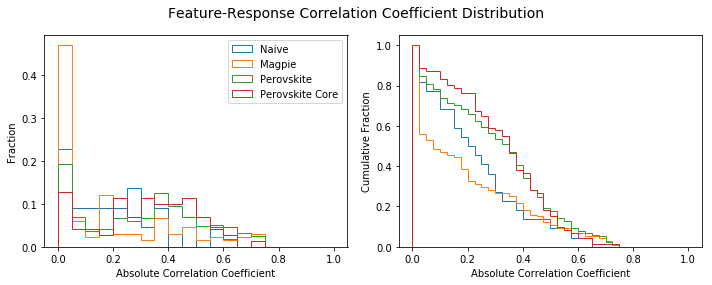

In [901]:
# plot feature-response correlation coefficients
fig, axes = plt.subplots(1,2,figsize=(10,4))

for lib, ldict in libraries.items():

    srt_cols, coefs = rank_correlation(ldict['Xy_tt'],'log_sigma',return_coef=True)
    
    # assign weights to get fraction of records in each bin
    axes[0].hist(coefs,histtype='step',bins=np.arange(0,1.001,0.05),label=lib,weights=np.ones_like(coefs)/len(coefs))
   
    axes[1].hist(coefs,histtype='step',bins=np.arange(0,1.001,0.025),label=lib,cumulative=-1,density=True)
   
        
for ax in axes:
    ax.set_xlabel('Absolute Correlation Coefficient')
axes[0].set_ylabel('Fraction')
axes[1].set_ylabel('Cumulative Fraction')
axes[0].legend()

fig.suptitle('Feature-Response Correlation Coefficient Distribution',size=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

The distributions above show that the MAGPIE library contains the largest fraction of features with little to no correlation with the response, while the full and core Perovskite libraries contain both the largest fractions features highly correlated to the response, and the features most correlated to the response.

In order to visualize some of the feature-response correlations, below we rank the features in each set by the absolute values of their Pearson correlation coefficients with the response. Pairplots of the response and the top 5 features in each library allow us to visualize the univariate correlation between each feature and the response, as well as correlations between features.

In [596]:
# rank features by their correlation coefficient with the response
for lib, ldict in libraries.items():
    ldict['corr_srt_cols'] = rank_correlation(ldict['Xy_tt'],'log_sigma')

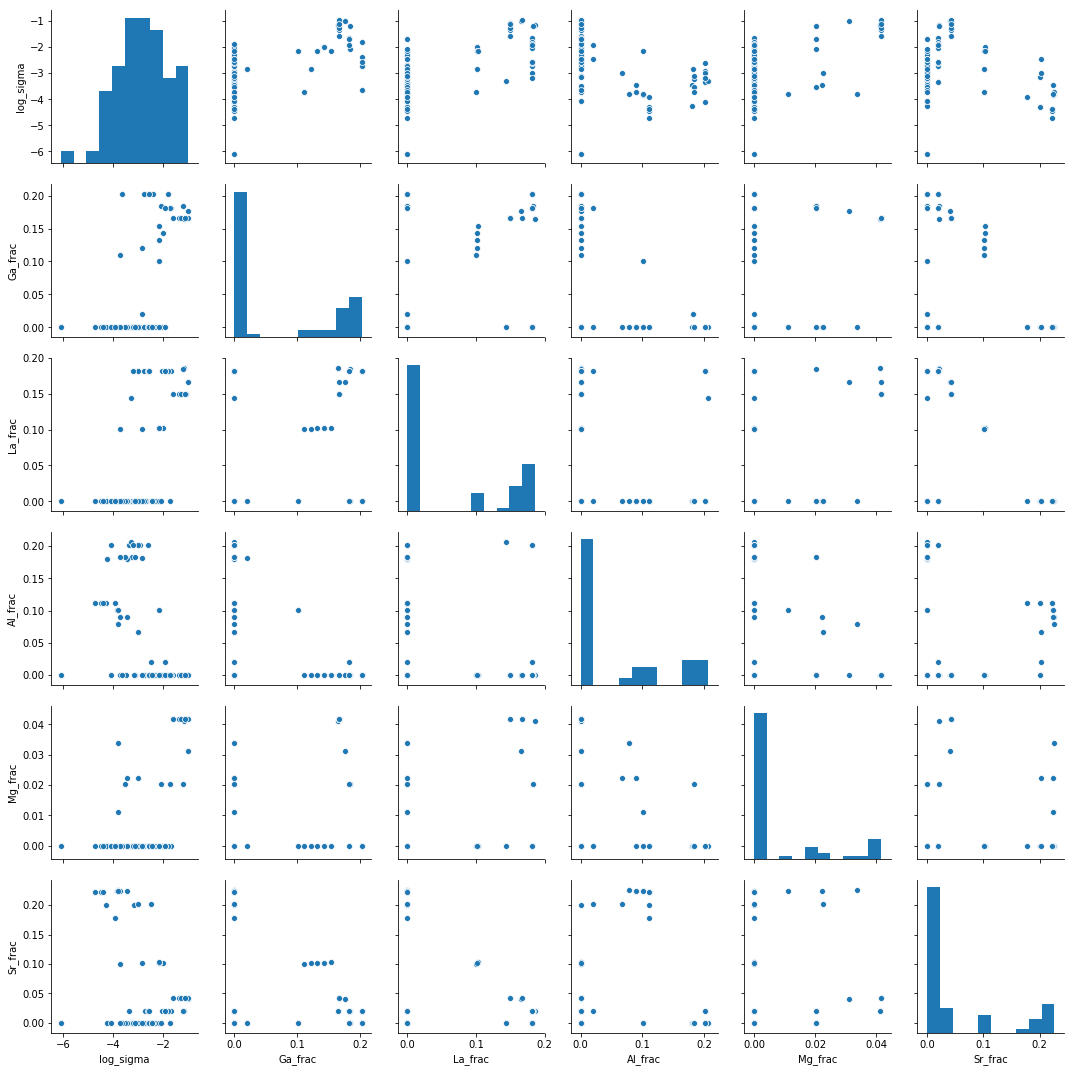

In [597]:
# Top 5 naive features
sn.pairplot(nv_Xy_tt,vars=['log_sigma'] + list(libraries['Naive']['corr_srt_cols'][:5]))

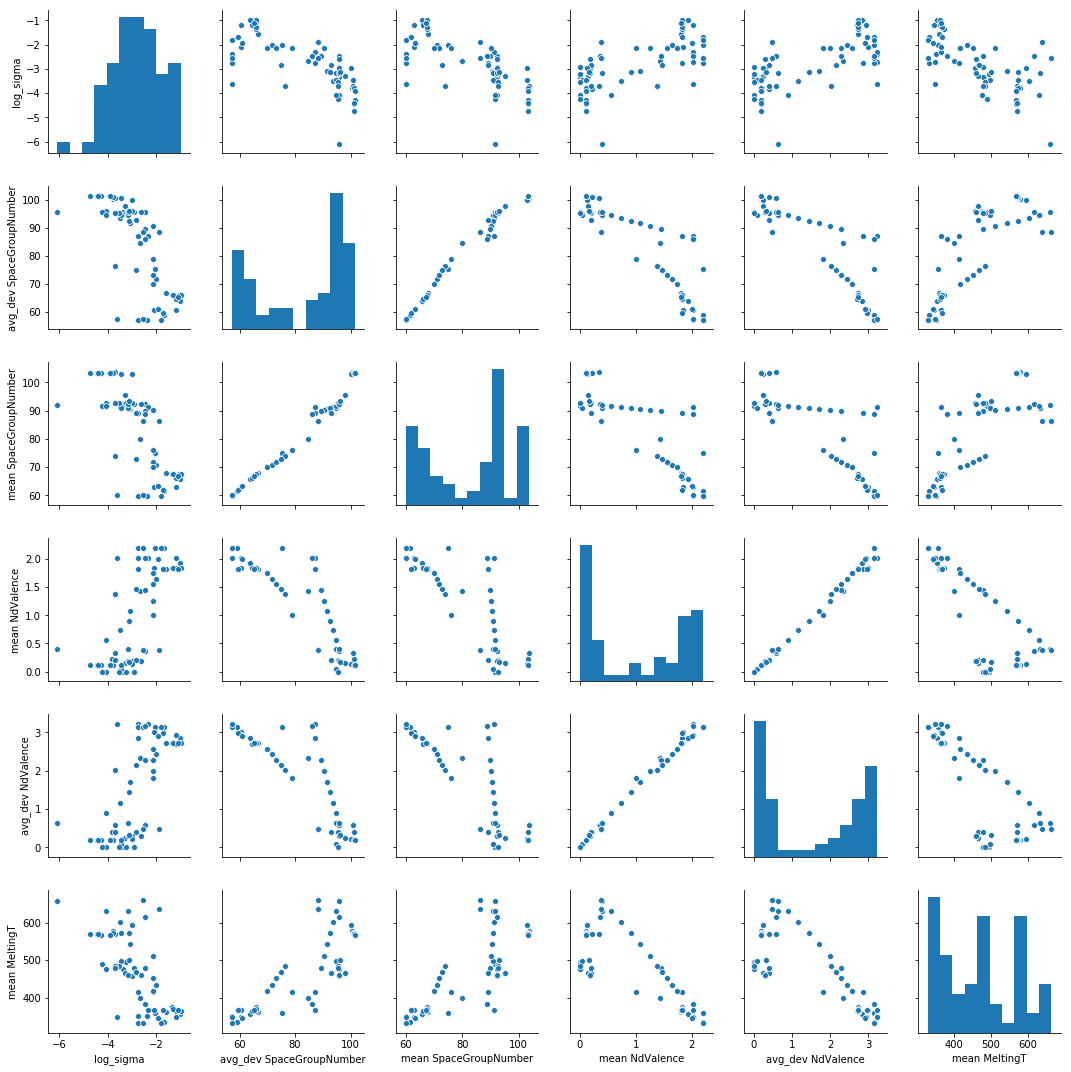

In [31]:
# Top 5 Magpie features
sn.pairplot(ep_Xy_tt,vars=['log_sigma'] + list(libraries['Magpie']['corr_srt_cols'][:5]))

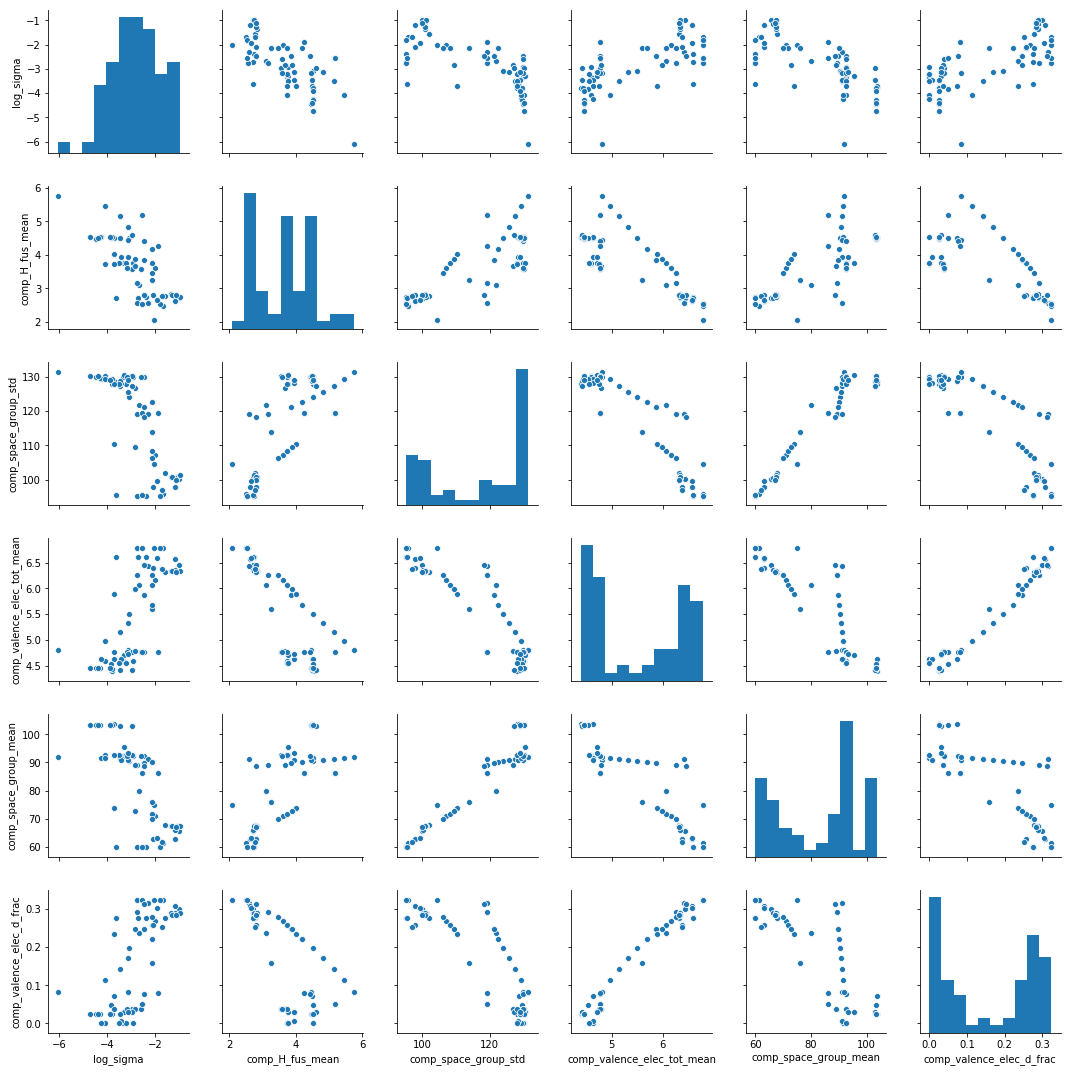

In [32]:
# Top 5 perovskite features
sn.pairplot(pk_Xy_tt,vars=['log_sigma'] + list(libraries['Perovskite']['corr_srt_cols'][:5]))

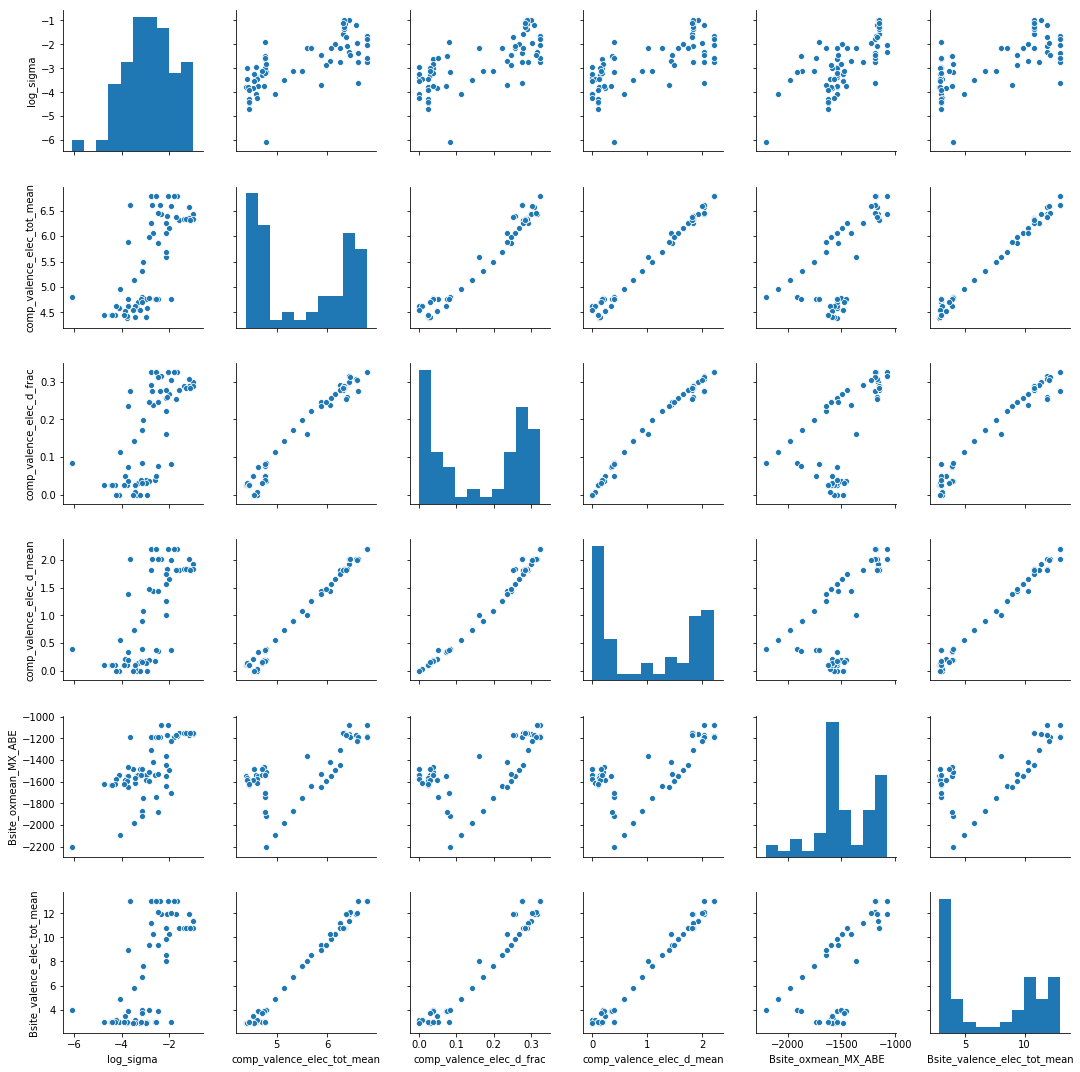

In [33]:
# Top 5 perovskite core features
sn.pairplot(pcore_Xy_tt,vars=['log_sigma'] + list(libraries['Perovskite Core']['corr_srt_cols'][:5]))

From the pairplots above, we can see that for the MAGPIE, Perovksite, and Perovskite Core libraries, some of the top features are highly correlated with each other. Thus, even though each feature is fairly well correlated with the response, the combination of multiple features may not provide much more information than a single feature. These feature-feature correlations arise both due to the nature of the features themselves (e.g., the mean number of d valence electrons is inherently related to the valence fraction of d electrons), and due to the materials dataset considered (i.e., some features may happen to correlate stronlgy for one particular set or class of materials, but not for another). We can account for this by considering feature-feature correlations.

### Feature-Feature Correlations

Just as we calculated correlation coefficients for feature-response relationships, we can do the same for feature-feature relationships.

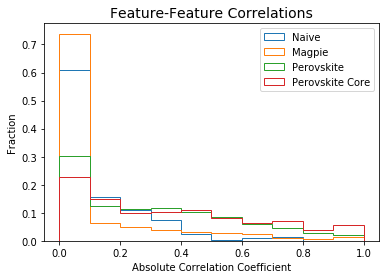

In [902]:
"Feature-feature correlations"
fig, ax = plt.subplots()
for lib, ldict in libraries.items():
    intercorr = np.corrcoef(ldict['X_tt'],rowvar=False)
    # only take the upper triangle to avoid duplicates and self-correlations
    intercorr = np.abs(np.nan_to_num(intercorr[np.triu_indices(intercorr.shape[0],k=1)],0))

    bins = np.arange(0,1.001,0.1)
    ax.hist(intercorr,histtype='step',bins=bins,label=lib,weights=np.ones_like(intercorr)/len(intercorr))
    
ax.set_title('Feature-Feature Correlations',size=14)
ax.set_xlabel('Absolute Correlation Coefficient')
ax.set_ylabel('Fraction')
ax.legend()

The distribution of feature-feature correlation coefficients above shows that the Perovskite libraries have the most intercorrelated features. We can thin the feature libraries by identifying sets of highly intercorrelated features (below we use a correlation coefficient threshold of 0.95 to identify intercorrelated groups), and keeping only one feature from each set of intercorrelated features. This results in an "independent" feature set consisting only of features that do not correlate strongly to any other features in the set.

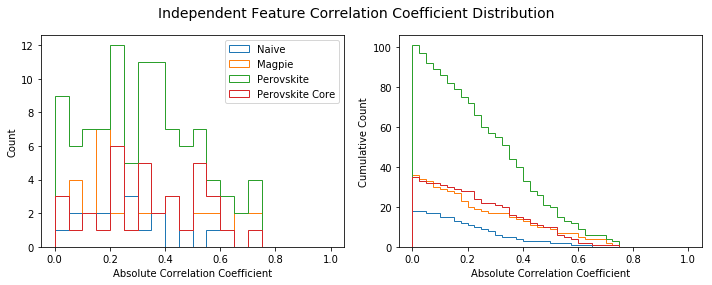

In [903]:
"Feature-Response Correlations for independent features"
fig, axes = plt.subplots(1,2,figsize=(10,4))
for lib, ldict in libraries.items():
    # get independent features
    ind = choose_independent_features(ldict['Xy_tt'],thresh=0.95,response_col='log_sigma')
    ldict['ind_features'] = ind
    srt_cols, coefs = rank_correlation(ldict['Xy_tt'].loc[:,ind+['log_sigma']],'log_sigma',return_coef=True)
    
    bins = np.arange(0,1.001,0.05)
    axes[0].hist(coefs,histtype='step',bins=bins,label=lib)#,weights=np.ones_like(ep_coefs)/len(ep_coefs))
    bins = np.arange(0,1.001,0.025)
    axes[1].hist(coefs,histtype='step',bins=bins,label=lib,cumulative=-1)#,density=True)

for ax in axes:
    ax.set_xlabel('Absolute Correlation Coefficient')
axes[0].set_ylabel('Count')
axes[1].set_ylabel('Cumulative Count')
axes[0].legend()

fig.suptitle('Independent Feature Correlation Coefficient Distribution',size=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

With this filtering, the Perovskite library still has the largest number of features highly correlated with the response, but the Magpie and Perovskite Core libraries now have similar feature-response correlation distributions.

# IV. Train and cross-validate models

We're now ready to train and cross-validate machine learning models on the training set. However, the number of features in each library is larger than ideal for this size of dataset - we should typically aim to have fewer features in our model than data points in our training set to appropriately fit the model. Additionally, if model interpretation is important to us, we should use as few features as possible for the most human-interpretable models. Feature selection is thus an important part of model construction - we need to select a subset of features that describes the response as fully and consistently as possible. To this end, we will explore four feature selection methods:
1. Correlation Ranking
1. Feature Importance Ranking
1. Elastic Net
1. Sequential Feature Selection

## A. Correlation Ranking

With this method, we simply use univariate feature-response correlations to rank features as we did above, and then choose the top $n$ features to go into our model. This is a simple *filter method*, in which features are selected based on a metric prior to any model construction. Below we use the top 5 features selected this way to construct models using a wide variety of learning algorithms, including linear, kernel, and ensemble methods. The 4-fold cross-validation (CV) results on the training set are shown below. For consistency, a single random state (`random_state=17`) is specified to ensure the same cross-validation splits in all cases (referred to as "CV split 17" in the rest of this notebook).

In [768]:
# set up estimators

ss = StandardScaler()

en = ElasticNet(alpha=1e-2,l1_ratio=0.1,max_iter=5000)
enp = Pipeline([('scale',ss), ('Elastic Net',en)])

svr = SVR(C=1)
svp = Pipeline([('scale',ss), ('SVR',svr)])

kr = KernelRidge(kernel='laplacian',alpha=1e-2)
krp = Pipeline([('scale',ss), ('Kernel Ridge',kr)])

rf = RandomForestRegressor(n_estimators=10, max_depth=5,random_state=17)
rfp = Pipeline([('scale',ss), ('Random Forest',rf)])

gb = GradientBoostingRegressor(n_estimators=10,learning_rate=0.4)
gbp = Pipeline([('scale',ss), ('Gradient Boosting',gb)])

estimators = [enp, svp, krp, rfp, gbp]

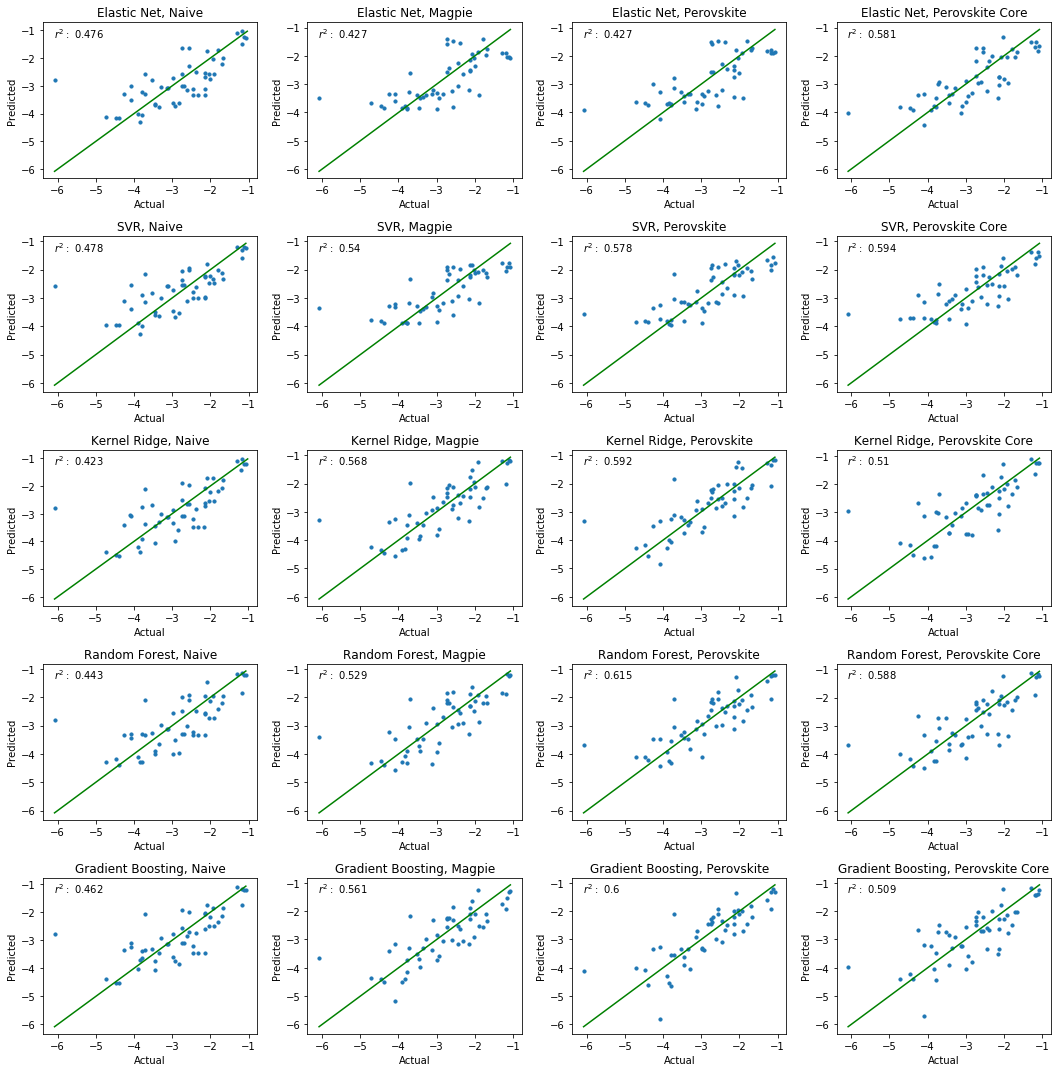

In [769]:
fig, axes = plt.subplots(5,4,figsize=(15,15))

n_feat = 5

for estimator,row in zip(estimators,axes):
    for (lib,ldict), ax in zip(libraries.items(),row):
        test_scores = mv.KFold_pva(estimator,ldict['X_tt'].loc[:,ldict['corr_srt_cols'][:n_feat]].values,y_tt,
                                   random_state=17,ax=ax)
        ax.set_title('{}, {}'.format(estimator.steps[1][0],lib))

fig.tight_layout()

The resulting $r^2$ scores range from ~0.35 to ~0.6. In general, the Perovskite libraries slightly outperform the naive and MAGPIE libraries. Some gain in performance is likely possible by optimizing hyperparameters, but at first glance the performance is mediocre.

We can perform the same selection using only independent features to avoid including redundant intercorrelated features.

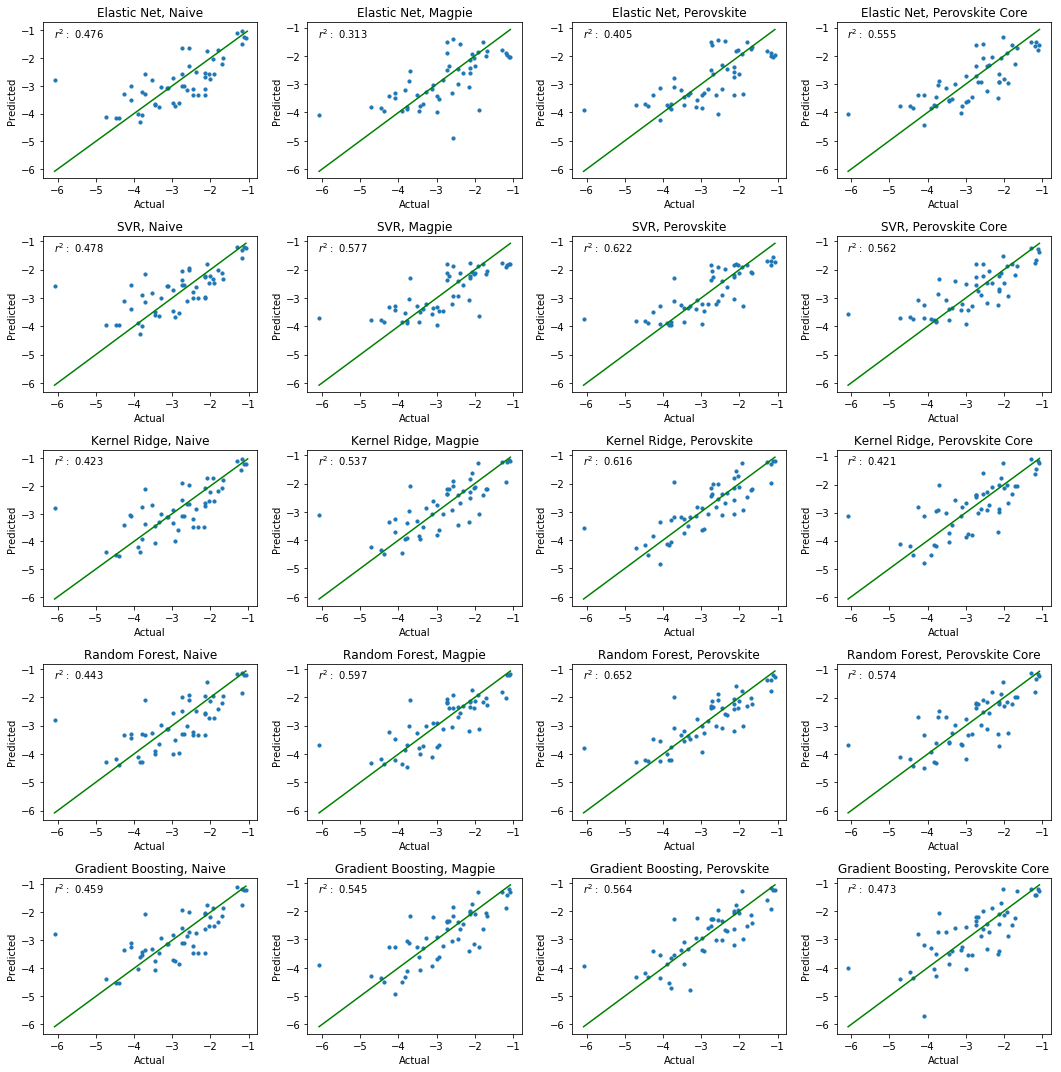

In [770]:
# use independent features

# rank independent features by their correlation coefficient with the response
for lib, ldict in libraries.items():
    cols = ldict['ind_features'] + ['log_sigma']
    ldict['corr_srt_cols_ind'] = rank_correlation(ldict['Xy_tt'].loc[:,cols],'log_sigma')
    
fig, axes = plt.subplots(5,4,figsize=(15,15))

n_feat = 5

for estimator,row in zip(estimators,axes):
    for (lib,ldict), ax in zip(libraries.items(),row):
        test_scores = mv.KFold_pva(estimator,ldict['X'].loc[:,ldict['corr_srt_cols_ind'][:n_feat]].values,y_tt,
                                   random_state=17,ax=ax)
        ax.set_title('{}, {}'.format(estimator.steps[1][0],lib))

fig.tight_layout()

Selecting from independent features only provides a marginal increase in performance.

For a more quantitative evaulation of performance, we can calculate cross validation scores for each estimator and library for the top 1-10 ranked features.

In [794]:
# calculate scores for this CV split for 1-10 features for each estimator and library
for lib,ldict in libraries.items():
    ldict['corr_srt_cv_scores'] = {}
    ldict['corr_srt_ind_cv_scores'] = {}
    for estimator in estimators:
        mean_scores = []
        mean_scores_ind = []
        for n_feat in range(1,11):
            act,pred,train_scores,test_scores = mv.KFold_cv(estimator,ldict['X_tt'].loc[:,ldict['corr_srt_cols'][:n_feat]].values,
                                                            y_tt,random_state=17)
            act,pred,train_scores,test_scores_ind = mv.KFold_cv(estimator,ldict['X_tt'].loc[:,ldict['corr_srt_cols_ind'][:n_feat]].values,
                                                            y_tt,random_state=17)
            mean_scores.append(np.mean(test_scores))
            mean_scores_ind.append(np.mean(test_scores_ind))
        ldict['corr_srt_cv_scores'][estimator.steps[1][0]] = mean_scores
        ldict['corr_srt_ind_cv_scores'][estimator.steps[1][0]] = mean_scores_ind

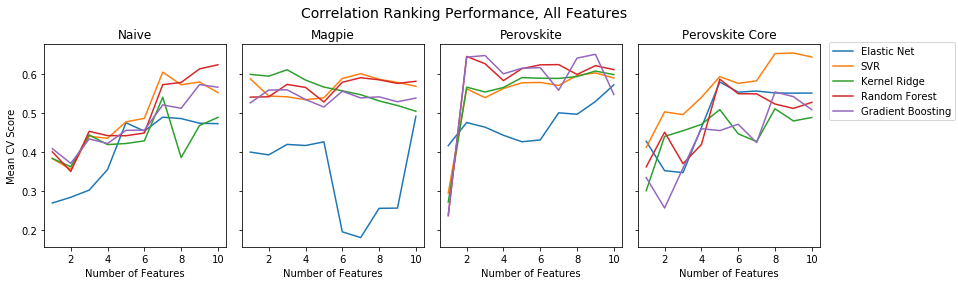

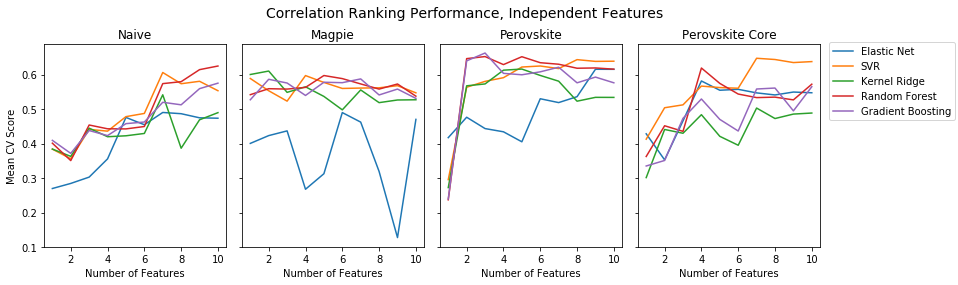

In [793]:
# plot scores
fig1, axes1 = plt.subplots(1,4,figsize=(13,4),sharey=True)
fig2, axes2 = plt.subplots(1,4,figsize=(13,4),sharey=True)

for estimator in estimators:
    for (lib, ldict), ax1,ax2 in zip(libraries.items(),axes1,axes2):
        est_name = estimator.steps[1][0]
        ax1.plot(np.arange(1,11),ldict['corr_srt_cv_scores'][est_name],label=est_name)
        ax2.plot(np.arange(1,11),ldict['corr_srt_ind_cv_scores'][est_name],label=est_name)
        for ax in [ax1,ax2]:
            ax.set_title(lib)
            ax.set_xlabel('Number of Features')
            
axes1[0].set_ylabel('Mean CV Score')
axes2[0].set_ylabel('Mean CV Score')

fig1.suptitle('Correlation Ranking Performance, All Features',size=14)
fig2.suptitle('Correlation Ranking Performance, Independent Features',size=14)

for fig in [fig1,fig2]:
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    h,l = fig.get_axes()[0].get_legend_handles_labels()
    fig.subplots_adjust(right=0.88)
    fig.legend(handles=h,labels=l,loc='upper left',bbox_to_anchor=(0.88,0.86))

While the plots are noisy, some general trends emerge. First, the linear Elastic Net model tends to perform poorly for all libraries except Perovskite Core, indicating that more complex non-linear relationships are needed to explain conductivity. Second, the full Perovskite library tends to perform best, followed by MAGPIE, Perovskite Core, and the naive feature set. Both the full Perovskite and MAGPIE libraries reach peak performance with few features, while the Naive and Perovskite Core libraries show increasing performance with additional features up to ~7-8 features.

While correlation ranking is a simple and fast method for feature selection, it considers only linear, univariate relationships and fails to take into account the combined power of multiple features.

## B. Feature Importance Ranking

Some estimators, such as random forest and gradient boosting regressors, return feature importance scores after fitting. These scores indicate the degree of influence that each feature has in the trained model, and can thus be used to rank features in the same manner as correlation coefficients. However, since ensemble models can learn more complex, multivariate relationships, and the importance scores are based on the features that provide the best model performance, ranking with these scores my produce a better feature set for modeling than simple correlation ranking.

Below, we fit a random forest regressor to the training set to calculate feature importance scores. Due to the random nature of the fitting, we repeat the process 20 times for each library, and weight each result by the cross-validation score. Again, we show predicted vs. actual plots for the top 5 features selected this way, for CV split 17.

In [628]:
# select features
rf_select = RandomForestRegressor(n_estimators=10, max_depth=5)
rfp_select = Pipeline([('scale',ss), ('Random Forest',rf_select)])

for lib, ldict in libraries.items():
    importances = np.zeros(len(ldict['X_tt'].columns))
    for i in range(20):
        # train RF models on 20 different train-test splits
        X_train, X_test, y_train, y_test = train_test_split(ldict['X_tt'],y_tt,test_size=0.2,shuffle=True)
        rfp.fit(X_train,y_train)
        score = rfp.score(X_test,y_test)
        #print(score)
        if score > 0:
            # weight results by validation score
            importances += score*rf.feature_importances_
            
    ldict['rf_srt_cols'] = ldict['X_tt'].columns[np.argsort(importances)[::-1]]

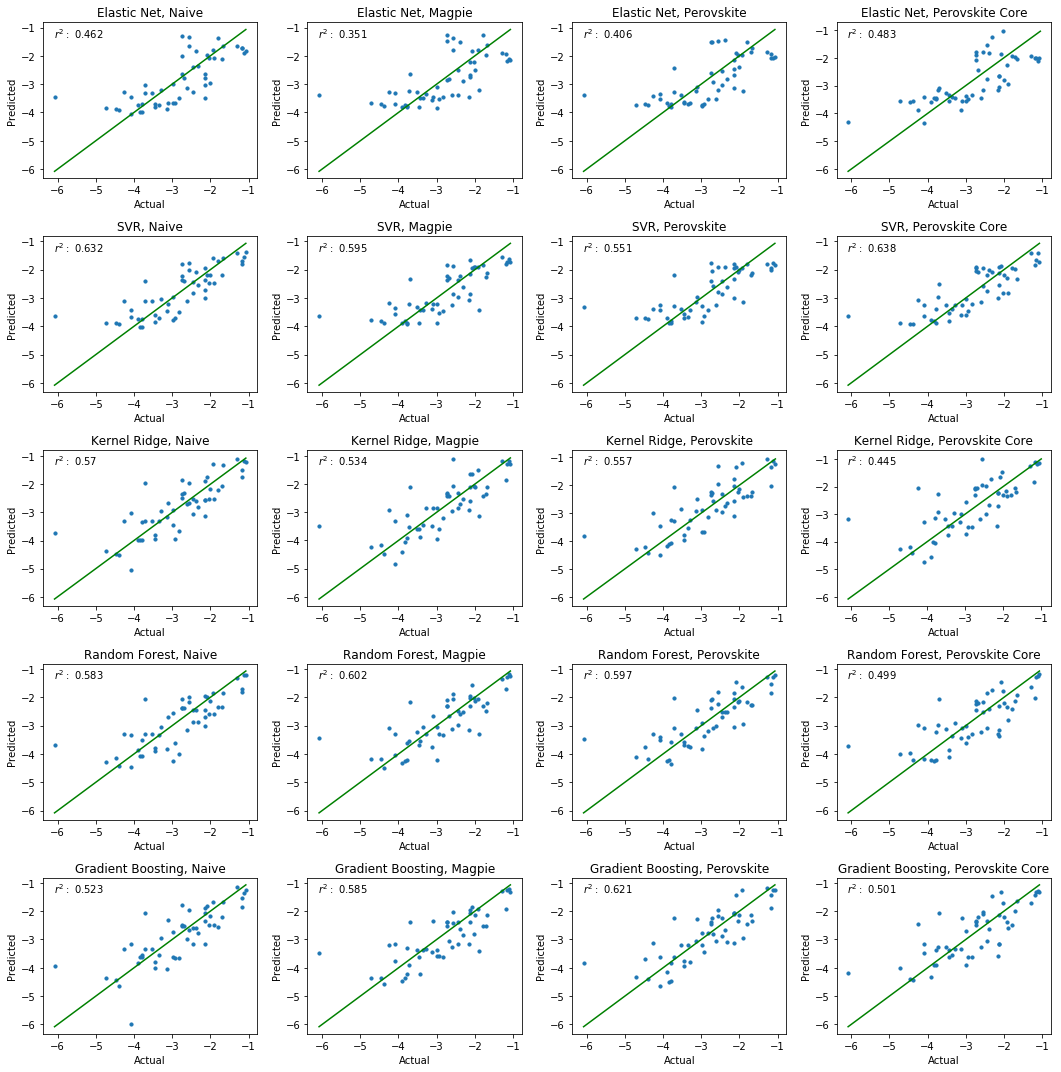

In [787]:
fig, axes = plt.subplots(5,4,figsize=(15,15))

n_feat = 5

for estimator,row in zip(estimators,axes):
    for (lib,ldict), ax in zip(libraries.items(),row):
        test_scores = mv.KFold_pva(estimator,ldict['X_tt'].loc[:,ldict['rf_srt_cols'][:n_feat]].values,
                                            y_tt,random_state=17,ax=ax)
        ax.set_title('{}, {}'.format(estimator.steps[1][0],lib))

fig.tight_layout()

In [789]:
# calculate scores for this CV split for 1-10 features for each estimator and library
for lib,ldict in libraries.items():
    ldict['rf_srt_cv_scores'] = {}
    for estimator in estimators:
        mean_scores = []
        for n_feat in range(1,11):
            act,pred,train_scores,test_scores = mv.KFold_cv(estimator,ldict['X_tt'].loc[:,ldict['rf_srt_cols'][:n_feat]].values,
                                                            y_tt,random_state=17)
            mean_scores.append(np.mean(test_scores))
        ldict['rf_srt_cv_scores'][estimator.steps[1][0]] = mean_scores

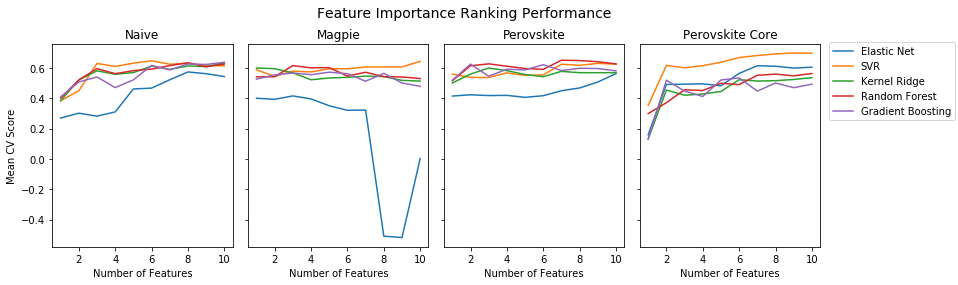

In [790]:
# plot scores
fig, axes = plt.subplots(1,4,figsize=(13,4),sharey=True)

for estimator in estimators:
    for (lib, ldict), ax in zip(libraries.items(),axes):
        est_name = estimator.steps[1][0]
        ax.plot(np.arange(1,11),ldict['rf_srt_cv_scores'][est_name],label=est_name)
        ax.set_title(lib)
        ax.set_xlabel('Number of Features')
            
axes[0].set_ylabel('Mean CV Score')
fig.suptitle('Feature Importance Ranking Performance',size=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
h,l = fig.get_axes()[0].get_legend_handles_labels()
fig.subplots_adjust(right=0.88)
fig.legend(handles=h,labels=l,loc='upper left',bbox_to_anchor=(0.88,0.86))

As with correlation ranking, most estimators perform similarly, with the exception of Elastic Net, which performs significiantly worse than other estimators for all libraries except Perovskite Core. MAGPIE and Perovskite show very similar performance for any number of features from 1-10, while Naive reaches the same performance with 3+ features. Perovskite Core lags behind the other feature sets with all estimators except for SVR. The maximum score attained is ~0.6 - about the same as with simple correlation ranking.

## C. Elastic Net

Another option for feature selection is to use an L1-penalized linear regression such as LASSO or Elastic Net. These methods apply a regularization penalty to the L1 norm of the feature coefficients, and optimize the sum of the model error plus this penalty. Such regularization balances model performance and complexity by producing a sparse coefficient vector, in which many coefficients are zero. This is an example of an *embedded method*, in which feature selection is embedded in the learning algorithm itself.

The disadvantage of this method is that it considers only linear relationships, but the features selected may be used in non-linear models.

In [635]:
# select 5 features with ElasticNet
en_select = ElasticNet(alpha=0.2,l1_ratio=0.95)
enp_select = Pipeline([('scale',ss),('en',en_select)])

for lib, ldict in libraries.items():
    # set alphas to get same number of selected features
    if lib=='Naive':
        en_select.set_params(alpha=0.3)
    elif lib=='Magpie':
        en_select.set_params(alpha=0.3)
    elif lib=='Perovskite':
        en_select.set_params(alpha=0.44)
    elif lib=='Perovskite Core':
        en_select.set_params(alpha=0.2)
    enp_select.fit(ldict['X_tt'].values,y_tt)
    nonzero = np.where(en_select.coef_!=0)
    ldict['en_cols'] = ldict['X_tt'].columns[nonzero]

# Check number of selected features
{k:len(v['en_cols']) for k,v in libraries.items()}

{'Magpie': 5, 'Naive': 5, 'Perovskite': 5, 'Perovskite Core': 5}

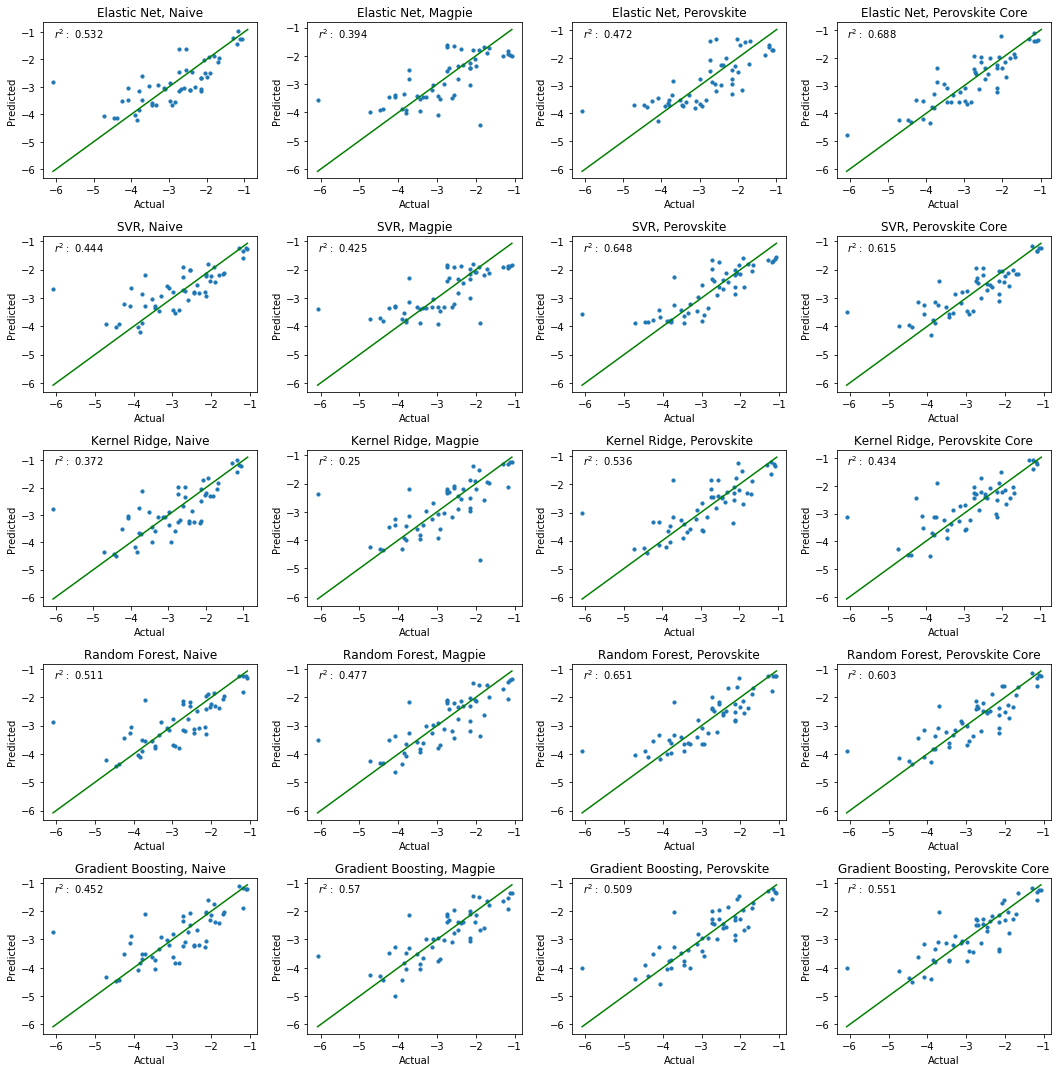

In [648]:
fig, axes = plt.subplots(5,4,figsize=(15,15))

for estimator,row in zip(estimators,axes):
    for (lib,ldict), ax in zip(libraries.items(),row):
        test_scores = mv.repeated_KFold_pva(estimator,ldict['X_tt'].loc[:,ldict['en_cols']].values,
                                            y_tt,repeat=10,plot_type='mean',ax=ax)
        ax.set_title('{}, {}'.format(estimator.steps[1][0],lib))

fig.tight_layout()

With 5 features selected by Elastic Net, Perovskite and Perovskite Core generally outperform the MAGPIE and Naive libraries. Despite the fact that the features were selected by a linear regressor, the non-linear algorithms tend to outperform the linear model.

Different numbers of features could be selected by adjusting the $\alpha$ parameter and retraining, but this is not done here.

## D. Sequential Feature Selection

A more sophisticated, but computationally expensive, feature selection method is sequential feature selection (SFS). This is a *wrapper method* that uses a specific learning algorithm to evaluate different feature sets. In forward sequential feature selection, shown below, we first select the single feature that results in the best cross-validation score using the chosen learning algorithm. We then determine which feature, when added to the first feature, results in the greatest improvement in cross-validation score. We continue this process until we reach the desired number of features.

The code below demonstrates the use of forward SFS on each library, using three different learning algorithms for feature subset evaluation.

In [649]:
ridge_for_selection = Ridge(alpha=1e-2)
rrp_for_selection = Pipeline([('scale',ss),('Ridge',ridge_for_selection)])

rf_for_selection = RandomForestRegressor(random_state=17)
rfp_for_selection = Pipeline([('scale',ss),('Random Forest',rf_for_selection)])

svr_for_selection = SVR(kernel='rbf',C=1)
svp_for_selection = Pipeline([('scale',ss),('SVR',svr_for_selection)])

# try:
#     #libraries = load_pickle('FeatureLibraryMetadata.pkl')
#     libraries = load_pickle('ssdFeatureLibraryMetadata_nonFloating.pkl')
# except FileNotFoundError:

# ensure that all SFS instances use same CV folds
cv = KFold(4,shuffle=True,random_state=17)

sfs_ridge = SFS(rrp_for_selection,
          k_features=10,
          forward=True,
          floating=False,
          verbose=2,
          scoring='r2',
          cv=cv,
          n_jobs=4)


sfs_rf = SFS(rfp_for_selection,
          k_features=10,
          forward=True,
          floating=False,
          verbose=2,
          scoring='r2',
          cv=cv,
          n_jobs=4)

sfs_svr = SFS(svp_for_selection,
          k_features=10,
          forward=True,
          floating=False,
          verbose=2,
          scoring='r2',
          cv=cv,
          n_jobs=4)

sfs_kr = SFS(krp_for_selection,
          k_features=10,
          forward=True,
          floating=False,
          verbose=2,
          scoring='r2',
          cv=cv,
          n_jobs=4)

for lib, ldict in libraries.items():

    print(lib,'Ridge')
    sfs_ridge.fit(ldict['X_tt'].values,y_tt,custom_feature_names=ldict['X_tt'].columns)
    print(lib,'RF')
    sfs_rf.fit(ldict['X_tt'].values,y_tt,custom_feature_names=ldict['X_tt'].columns)
    print(lib,'SVR')
    sfs_svr.fit(ldict['X_tt'].values,y_tt,custom_feature_names=ldict['X_tt'].columns)
    print(lib,'KR')
    sfs_kr.fit(ldict['X_tt'].values,y_tt,custom_feature_names=ldict['X_tt'].columns)
    ldict['SFS_ridge_subsets'] = sfs_ridge.subsets_
    ldict['SFS_rf_subsets'] = sfs_rf.subsets_
    ldict['SFS_svr_subsets'] = sfs_svr.subsets_

#save_pickle(libraries,'FeatureLibraryMetadata.pkl')
#     save_pickle(libraries,'FeatureLibraryMetadata_nonFloating.pkl')

Naive Ridge


[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:    1.5s finished

[2019-07-25 11:33:27] Features: 1/10 -- score: 0.22790205349237724[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    1.6s finished

[2019-07-25 11:33:30] Features: 2/10 -- score: 0.36638184046768385[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.7s finished

[2019-07-25 11:33:33] Features: 3/10 -- score: 0.4909693614692157[Parallel(n_jobs=4)]: Done  19 out of  19 | elapsed:    1.7s finished

[2019-07-25 11:33:36] Features: 4/10 -- score: 0.5656140820224649[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    2.3s finished

[2019-07-25 11:33:40] Features: 5/10 -- score: 0.5804791434415517[Parallel(n_jobs=4)]: Done  17 out of  17 | elapsed:    2.1s finished

[2019-07-25 11:33:43] Features: 6/10 -- score: 0.5822326786379539[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.6s finished

[2019-07-25 11:33:46] Features: 7/10 -- score: 0.582232678637954[Parallel(n_jobs=4)]: Done  15 out of  15 | ela

Naive RF


[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:    1.6s finished

[2019-07-25 11:33:57] Features: 1/10 -- score: 0.34494072671800846[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    1.7s finished

[2019-07-25 11:34:00] Features: 2/10 -- score: 0.47006350110133166[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.6s finished

[2019-07-25 11:34:03] Features: 3/10 -- score: 0.5649587289620822[Parallel(n_jobs=4)]: Done  19 out of  19 | elapsed:    1.6s finished

[2019-07-25 11:34:06] Features: 4/10 -- score: 0.5929648702536178[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    1.6s finished

[2019-07-25 11:34:08] Features: 5/10 -- score: 0.6051827723073508[Parallel(n_jobs=4)]: Done  17 out of  17 | elapsed:    1.6s finished

[2019-07-25 11:34:11] Features: 6/10 -- score: 0.6021138671282454[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.6s finished

[2019-07-25 11:34:14] Features: 7/10 -- score: 0.5988577008654936[Parallel(n_jobs=4)]: Done  15 out of  15 | el

Naive SVR


[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:    1.5s finished

[2019-07-25 11:34:25] Features: 1/10 -- score: 0.3557859623030371[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    1.5s finished

[2019-07-25 11:34:28] Features: 2/10 -- score: 0.4857729042999237[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.5s finished

[2019-07-25 11:34:31] Features: 3/10 -- score: 0.6262824514288238[Parallel(n_jobs=4)]: Done  19 out of  19 | elapsed:    1.6s finished

[2019-07-25 11:34:34] Features: 4/10 -- score: 0.6462371114941461[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    1.5s finished

[2019-07-25 11:34:36] Features: 5/10 -- score: 0.6536186053868319[Parallel(n_jobs=4)]: Done  17 out of  17 | elapsed:    1.5s finished

[2019-07-25 11:34:39] Features: 6/10 -- score: 0.6646382881526324[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.5s finished

[2019-07-25 11:34:42] Features: 7/10 -- score: 0.6592702018800527[Parallel(n_jobs=4)]: Done  15 out of  15 | elap

Naive KR


[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:    1.6s finished

[2019-07-25 11:34:52] Features: 1/10 -- score: 0.40125099134947206[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    1.5s finished

[2019-07-25 11:34:55] Features: 2/10 -- score: 0.5060340714508245[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.5s finished

[2019-07-25 11:34:58] Features: 3/10 -- score: 0.5719082137989833[Parallel(n_jobs=4)]: Done  19 out of  19 | elapsed:    1.5s finished

[2019-07-25 11:35:00] Features: 4/10 -- score: 0.6176179231345307[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    1.5s finished

[2019-07-25 11:35:03] Features: 5/10 -- score: 0.6380054388465723[Parallel(n_jobs=4)]: Done  17 out of  17 | elapsed:    1.5s finished

[2019-07-25 11:35:06] Features: 6/10 -- score: 0.6564652291028381[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.5s finished

[2019-07-25 11:35:08] Features: 7/10 -- score: 0.6734616208386024[Parallel(n_jobs=4)]: Done  15 out of  15 | ela

In [642]:
save_pickle(libraries,'tmp_lib')

Dumped pickle to tmp_lib


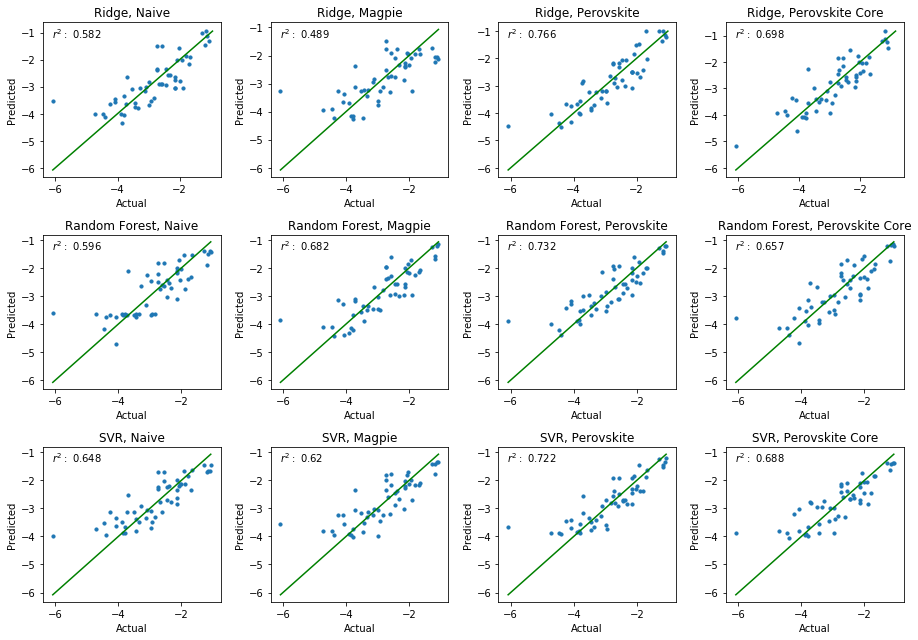

In [655]:
# PVA for each estimator used in SFS, with its 10 selected features
fig, axes = plt.subplots(3,4,figsize=(13,9))

selectors = [rrp_for_selection, rfp_for_selection, svp_for_selection] #, krp_for_selection]

for estimator,row in zip(selectors,axes):
    for (lib,ldict), ax in zip(libraries.items(),row):
        if estimator==rrp_for_selection:
            cols = list(ldict['SFS_ridge_subsets'][10]['feature_names'])
        elif estimator==svp_for_selection:
            cols = list(ldict['SFS_svr_subsets'][10]['feature_names'])
        elif estimator==rfp_for_selection:
            cols = list(ldict['SFS_rf_subsets'][10]['feature_names'])
        else: print('estimator not in list')
            
        train_scores, test_scores, tot_score = mv.KFold_pva(estimator,ldict['X_tt'].loc[:,cols].values,y_tt, 
                                                            k=4, random_state=17,ax=ax)
        ax.set_title('{}, {}'.format(estimator.steps[1][0],lib))

fig.tight_layout()

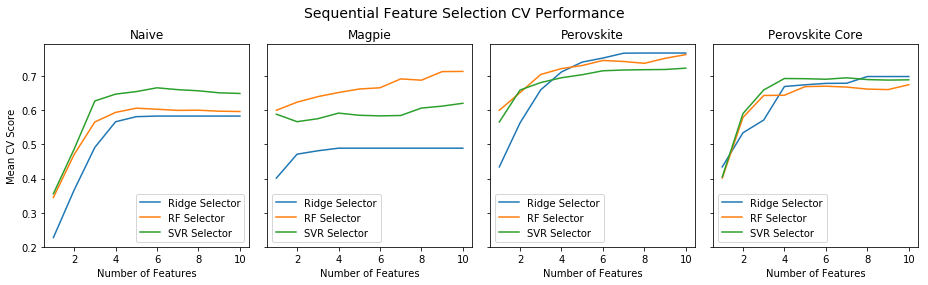

In [651]:
# r2 as function of number of features selected
fig, axes = plt.subplots(1,4,figsize=(13,4),sharey=True)

for (lib,ldict), ax in zip(libraries.items(),axes):
    ax.plot(ldict['SFS_ridge_subsets'].keys(),[v['avg_score'] for v in ldict['SFS_ridge_subsets'].values()],label='Ridge Selector')
    ax.plot(ldict['SFS_rf_subsets'].keys(),[v['avg_score'] for v in ldict['SFS_rf_subsets'].values()],label='RF Selector')
    ax.plot(ldict['SFS_svr_subsets'].keys(),[v['avg_score'] for v in ldict['SFS_svr_subsets'].values()],label='SVR Selector')
    #ax.plot(ldict['SFS_kr_subsets'].keys(),[v['avg_score'] for v in ldict['SFS_kr_subsets'].values()],label='KR Selector')

    ax.legend()
    ax.set_xlabel('Number of Features')
    ax.set_title(lib)
    
axes[0].set_ylabel('Mean CV Score')
fig.tight_layout()
fig.suptitle('Sequential Feature Selection CV Performance',size=14)
fig.subplots_adjust(top=0.85)


With this method, we achieve significantly better CV scores than with the previous feature selection methods.  Perovskite and Perovskite Core generally exhibit the best performance, while MAGPIE and Naive vary in performance depending on the learning algorithm used for selection.

Since the SFS has provided a decent level of performance with the selected features, we can consider hyperparameter tuning. Each learning algorithm has its own set of hyperparameters that determine how the model fits the training data. For example, the regularization level $\alpha$ in Elastic Net determines how large of a penalty is applied to feature coefficients, while the number of trees and tree depth in a random forest affect the level of bias in the resulting model. The choice of hyperparameters can have a significant impact on model performance, but the optimal hyperparameters may vary for each library and number of features. Thus, optimizing the hyperparameters for each case provides a better performance comparison. To further examine cross validation performance, we optimize the model hyperparameters on the training set for each learning algorithm, library, and number of selected features. Initially, for consistency, we optimize the hyperparameters for CV split 17.

In [657]:
# optimize ridge hyperparameters for this CV split for each library for 1-10 features and record CV scores
for (lib,ldict) in libraries.items():
    ridge_for_gs = Ridge()
    rrp_for_gs = Pipeline([('scale',ss),('ridge',ridge_for_gs)])
    gs = GridSearchCV(rrp_for_gs,cv=KFold(4,shuffle=True,random_state=17),
                      param_grid={'ridge__alpha':np.logspace(-3,0,20)})
    # optimize for 1-10 features
    ldict['ridge_optimized_scores'] = {}
    for n_feat in range(1,11):
        X = ldict['X_tt'].loc[:, ldict['SFS_ridge_subsets'][n_feat]['feature_names']]
        gs.fit(X,y_tt)
        est = gs.best_estimator_
        act, pred, train_scores, test_scores = mv.KFold_cv(est,X,y_tt,k=4,random_state=17)
        ldict['ridge_optimized_scores'][n_feat] = {'cv_mean':np.mean(test_scores),'cv_total':r_squared(act,pred)}
        print(lib, n_feat, ldict['ridge_optimized_scores'][n_feat])

Naive 1 {'cv_mean': 0.23616192726002175, 'cv_total': 0.32610078134977216}
Naive 2 {'cv_mean': 0.37802742454153254, 'cv_total': 0.46132062697696863}
Naive 3 {'cv_mean': 0.4991504083601874, 'cv_total': 0.5559804823143829}
Naive 4 {'cv_mean': 0.5713865712308775, 'cv_total': 0.631800931458993}
Naive 5 {'cv_mean': 0.5870389485627749, 'cv_total': 0.6397038121553225}
Naive 6 {'cv_mean': 0.588252391695402, 'cv_total': 0.6373470254794094}
Naive 7 {'cv_mean': 0.5882523916954021, 'cv_total': 0.6373470254794094}
Naive 8 {'cv_mean': 0.5882523916954022, 'cv_total': 0.6373470254794094}
Naive 9 {'cv_mean': 0.5882523916954022, 'cv_total': 0.6373470254794094}
Naive 10 {'cv_mean': 0.5882523916954022, 'cv_total': 0.6373470254794094}
Magpie 1 {'cv_mean': 0.4086419162982428, 'cv_total': 0.46398260448790674}
Magpie 2 {'cv_mean': 0.4773881725216849, 'cv_total': 0.5181619301528528}
Magpie 3 {'cv_mean': 0.48644949447735775, 'cv_total': 0.52547391039716}
Magpie 4 {'cv_mean': 0.4925519646631019, 'cv_total': 0.530

In [658]:
# optimize RF hyperparameters for this CV split for each library for 1-10 features and record CV scores
for (lib,ldict) in libraries.items():
    rf_for_gs = RandomForestRegressor(random_state=17)
    rfp_for_gs = Pipeline([('scale',ss),('rf',rf_for_gs)])
    gs = GridSearchCV(rfp_for_gs,cv=KFold(4,shuffle=True,random_state=17),
                      param_grid={'rf__n_estimators':[5,10,15,20],'rf__max_depth':[None,1,2,3,4,5,10]})
    # optimize for 1-10 features
    ldict['rf_optimized_scores'] = {}
    for n_feat in range(1,11):
        X = ldict['X_tt'].loc[:, ldict['SFS_rf_subsets'][n_feat]['feature_names']]
        gs.fit(X,y_tt)
        est = gs.best_estimator_
        act, pred, train_scores, test_scores = mv.KFold_cv(est,X,y_tt,k=4,random_state=17)
        ldict['rf_optimized_scores'][n_feat] = {'cv_mean':np.mean(test_scores),'cv_total':r_squared(act,pred)}
        print(lib, n_feat, gs.best_params_,ldict['rf_optimized_scores'][n_feat])

Naive 1 {'rf__max_depth': 4, 'rf__n_estimators': 20} {'cv_mean': 0.35065063883835995, 'cv_total': 0.4157737035869161}
Naive 2 {'rf__max_depth': 4, 'rf__n_estimators': 15} {'cv_mean': 0.47281194555140904, 'cv_total': 0.5264252212760967}
Naive 3 {'rf__max_depth': 3, 'rf__n_estimators': 10} {'cv_mean': 0.5720024036694444, 'cv_total': 0.6250200631159666}
Naive 4 {'rf__max_depth': None, 'rf__n_estimators': 10} {'cv_mean': 0.5928939762461746, 'cv_total': 0.6375972781244905}
Naive 5 {'rf__max_depth': None, 'rf__n_estimators': 10} {'cv_mean': 0.5903047769041734, 'cv_total': 0.6253227074538983}
Naive 6 {'rf__max_depth': None, 'rf__n_estimators': 10} {'cv_mean': 0.5961069153773179, 'cv_total': 0.6352193175833818}
Naive 7 {'rf__max_depth': 5, 'rf__n_estimators': 10} {'cv_mean': 0.5872657350559429, 'cv_total': 0.6298570042542196}
Naive 8 {'rf__max_depth': None, 'rf__n_estimators': 10} {'cv_mean': 0.5935643930904512, 'cv_total': 0.6431712359757964}
Naive 9 {'rf__max_depth': None, 'rf__n_estimators'

In [659]:
# optimize SVR hyperparameters for this CV split for each library for 1-10 features and record CV scores
for (lib,ldict) in libraries.items():
    svr_for_gs = SVR()  
    svp_for_gs = Pipeline([('scale',ss),('svr',svr_for_gs)])
    gs = GridSearchCV(svp_for_gs,cv=KFold(4,shuffle=True,random_state=17),
                      param_grid={'svr__C':np.logspace(-1,1,10),'svr__gamma':np.logspace(-1,1,10)})
    # optimize for 1-10 features
    ldict['svr_optimized_scores'] = {}
    for n_feat in range(1,11):
        X = ldict['X_tt'].loc[:, ldict['SFS_svr_subsets'][n_feat]['feature_names']]
        gs.fit(X,y_tt)
        est = gs.best_estimator_
        act, pred, train_scores, test_scores = mv.KFold_cv(est,X,y_tt,k=4,random_state=17)
        ldict['svr_optimized_scores'][n_feat] = {'cv_mean':np.mean(test_scores),'cv_total':r_squared(act,pred)}
        print(lib, n_feat, gs.best_params_,ldict['svr_optimized_scores'][n_feat])

Naive 1 {'svr__C': 5.994842503189409, 'svr__gamma': 2.1544346900318834} {'cv_mean': 0.4551552418862327, 'cv_total': 0.4765850276173448}
Naive 2 {'svr__C': 1.291549665014884, 'svr__gamma': 3.593813663804626} {'cv_mean': 0.525914583491116, 'cv_total': 0.5283263681003442}
Naive 3 {'svr__C': 5.994842503189409, 'svr__gamma': 0.16681005372000587} {'cv_mean': 0.6631316294053626, 'cv_total': 0.7175145401479093}
Naive 4 {'svr__C': 2.1544346900318834, 'svr__gamma': 0.16681005372000587} {'cv_mean': 0.6678219691832213, 'cv_total': 0.7016395659681876}
Naive 5 {'svr__C': 2.1544346900318834, 'svr__gamma': 0.16681005372000587} {'cv_mean': 0.6810858826846208, 'cv_total': 0.7163663875988837}
Naive 6 {'svr__C': 2.1544346900318834, 'svr__gamma': 0.16681005372000587} {'cv_mean': 0.6878364167218828, 'cv_total': 0.7212224645625109}
Naive 7 {'svr__C': 2.1544346900318834, 'svr__gamma': 0.16681005372000587} {'cv_mean': 0.6773269912653277, 'cv_total': 0.7152372396015325}
Naive 8 {'svr__C': 2.1544346900318834, 's

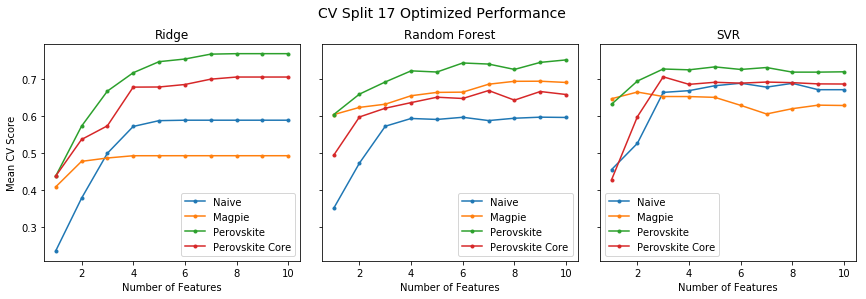

In [800]:
fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)

# plot optimized ridge CV score for each library as function of number of features
for lib, ldict in libraries.items():
    n = ldict['ridge_optimized_scores'].keys()
    #tot_scores = [v['cv_total'] for v in ldict['ridge_optimized_scores'].values()]
    mean_scores = [v['cv_mean'] for v in ldict['ridge_optimized_scores'].values()]
    p = axes[0].plot(n,mean_scores,label=lib,marker='.')
    
axes[0].legend()
axes[0].set_title('Ridge')

# plot optimized RF CV score for each library as function of number of features
for lib, ldict in libraries.items():
    n = ldict['rf_optimized_scores'].keys()
    #tot_scores = [v['cv_total'] for v in ldict['rf_optimized_scores'].values()]
    mean_scores = [v['cv_mean'] for v in ldict['rf_optimized_scores'].values()]
    p = axes[1].plot(n,mean_scores,label=lib,marker='.')
    #ax.plot(n,mean_scores,label=lib,marker='s') # ,color=p[0].get_color())
    
axes[1].legend()
axes[1].set_title('Random Forest')

fig.tight_layout()

# plot optimized SVR CV score for each library as function of number of features
for lib, ldict in libraries.items():
    n = ldict['svr_optimized_scores'].keys()
    #tot_scores = [v['cv_total'] for v in ldict['svr_optimized_scores'].values()]
    mean_scores = [v['cv_mean'] for v in ldict['svr_optimized_scores'].values()]
    p = axes[2].plot(n,mean_scores,label=lib,marker='.')
    #ax.plot(n,mean_scores,label=lib,marker='s') # ,color=p[0].get_color())
    
axes[2].legend()
axes[2].set_title('SVR')

     
axes[0].set_ylabel('Mean CV Score')
for ax in axes:
    ax.set_xlabel('Number of Features')

fig.suptitle('CV Split 17 Optimized Performance',size=14)
fig.subplots_adjust(top=0.85)


The optimized results show that Perovskite and Perovskite Core generally achieve the best CV scores, while MAGPIE and Naive reach lower performance levels, although there is some variation depending on estimator.

For a true test of performance, we need to use the trained models to predict the holdout. The optimal hyperparameters are sensitive to the cross-validation split that is used, so it is best to sample several cross-validation splits to get a distribution of optimized hyperparameters. From this distribution, we can make a better-informed choice of hyperparameters to use for the final training of the model on the full train-test set prior to predicting the holdout. Below, we sample 5 random CV splits for each model, and choose conservative (low bias) hyperparameter values from the resulting hyperparameter distributions. The chosen hyperparameters are then evaluated on the train-test set with repeated, randomized cross-validation.

In [972]:
#r = np.random.RandomState(1234)
r.randint(0,100,10)

array([50, 76, 37, 34, 38, 67, 11,  0, 75, 80])

In [979]:
# Ridge: train and predict holdout for 1-10 features
for lib,ldict in libraries.items():
    print(lib)
    
    for n in range(1,11):
        X = ldict['X_tt'].loc[:, ldict['SFS_ridge_subsets'][n]['feature_names']]

        # optimize for general CV on training set
        alpha_vals = []
        for seed in [3,11,37,6,89]:
            # GridSearch hyperparameters depend significantly on random split
            # Repeat GridSearch for more stable hyperparameters
            gs = GridSearchCV(rrp_for_gs,cv=KFold(4,shuffle=True,random_state=seed),
                      param_grid={'ridge__alpha':np.logspace(-3,1,20)})
            gs.fit(X,y_tt)
            alpha_vals.append(gs.best_params_['ridge__alpha'])
        alpha = np.max(alpha_vals) #choose max alpha to be conservative
        print(f'{n} features:', 'alpha:',np.round(alpha_vals,4), round(alpha,4))
        ldict[f'ridge_gs_params_{n}'] = {'ridge__alpha':alpha}
        
        # CV on training set
        est = gs.best_estimator_
        # use optimized params
        est.set_params(ridge__alpha=alpha)
        act,pred, scores = mv.repeated_KFold_cv(est,X,y_tt,repeat=10,k=4,random_state=23)
        ldict[f'ridge_gs_cv_score_{n}'] = np.mean(scores)
        
        # test as-optimized hyperparameters on holdout 
        X_ho = ldict['X_ho'].loc[:, ldict['SFS_ridge_subsets'][n]['feature_names']]
        est.fit(X,y_tt)
        ldict[f'ridge_gs_ho_score_{n}'] = est.score(X_ho,y_ho)
        
        # adjust alpha for larger training set
        est.set_params(ridge__alpha=2*alpha)
        est.fit(X,y_tt)
        ldict[f'ridge_gs_ho_score_2alpha_{n}'] = est.score(X_ho,y_ho)

Naive
1 features: alpha: [ 2.3357  3.7927  3.7927  6.1585 10.    ] 10.0
2 features: alpha: [0.5456 0.8859 2.3357 3.7927 6.1585] 6.1585
3 features: alpha: [0.8859 0.336  1.4384 3.7927 3.7927] 3.7927
4 features: alpha: [ 3.7927  3.7927  2.3357 10.      6.1585] 10.0
5 features: alpha: [ 3.7927  3.7927  6.1585 10.      6.1585] 10.0
6 features: alpha: [ 3.7927  3.7927  6.1585 10.      6.1585] 10.0
7 features: alpha: [ 3.7927  3.7927  6.1585 10.      6.1585] 10.0
8 features: alpha: [ 3.7927  3.7927  6.1585 10.      6.1585] 10.0
9 features: alpha: [ 3.7927  3.7927  6.1585 10.      6.1585] 10.0
10 features: alpha: [ 3.7927  3.7927  6.1585 10.      6.1585] 10.0
Magpie
1 features: alpha: [ 0.8859  2.3357  2.3357  6.1585 10.    ] 10.0
2 features: alpha: [ 0.8859  3.7927  3.7927  6.1585 10.    ] 10.0
3 features: alpha: [ 0.5456  3.7927 10.     10.     10.    ] 10.0
4 features: alpha: [ 1.4384  1.4384 10.     10.     10.    ] 10.0
5 features: alpha: [ 1.4384  1.4384 10.     10.     10.    ] 10.0
6 

In [985]:
# Random Forest: train and predict holdout for 1-10 features
for lib,ldict in libraries.items():
    print(lib)
    
    for n in range(1,11):
        X = ldict['X_tt'].loc[:, ldict['SFS_rf_subsets'][n]['feature_names']]

        # optimize for general CV on training set
        gs_params = []
        for seed in [3,11,37,6,89]:
            # GridSearch hyperparameters depend significantly on random split
            # Repeat GridSearch for more stable hyperparameters
            gs = GridSearchCV(rfp_for_gs,cv=KFold(4,shuffle=True,random_state=seed),
                      param_grid={'rf__n_estimators':[5,10,15,20],'rf__max_depth':[None,1,2,3,4,5,10]})
            gs.fit(X,y_tt)
            gs_params.append(gs.best_params_)
        n_est_vals = [gd['rf__n_estimators'] for gd in gs_params]
        n_est = int(np.median(n_est_vals)) # choose median n_estimators to balance bias and variance 
        depth_vals = [gd['rf__max_depth'] for gd in gs_params]
        none_conv = lambda x: np.inf if x==None else x # convert None to inf
        depth = np.min([none_conv(d) for d in depth_vals]) # choose min depth to be conservative
        if depth==np.inf:
            depth=None
        else:
            depth = int(depth)
        
        print(f'{n} features:', 'n_estimators:',n_est_vals, n_est, 'max_depth:',depth_vals,depth)
        ldict[f'rf_gs_params_{n}'] = {'rf__n_estimators':n_est,'rf__max_depth':depth}
        
        # CV on training set
        est = gs.best_estimator_
        # use optimized params
        est.set_params(rf__n_estimators=n_est,rf__max_depth=depth)
        act, pred, scores = mv.repeated_KFold_cv(est,X,y_tt,repeat=10,k=4,random_state=23)
        ldict[f'rf_gs_cv_score_{n}'] = np.mean(scores)
        
        # test as-optimized hyperparameters on holdout 
        X_ho = ldict['X_ho'].loc[:, ldict['SFS_ridge_subsets'][n]['feature_names']]
        est.fit(X,y_tt)
        ldict[f'rf_gs_ho_score_{n}'] = est.score(X_ho,y_ho)
        
        # reduce max_depth
        if depth==None:
            halfdepth = 10
        else:
            halfdepth = max(1,int(depth/2))
        est.set_params(rf__max_depth=halfdepth)
        est.fit(X,y_tt)
        ldict[f'rf_gs_ho_score_halfdepth_{n}'] = est.score(X_ho,y_ho)
        
        # reduce n_estimators
        half_n_est = int(n_est/2)
        est.set_params(rf__n_estimators=half_n_est,rf__max_depth=depth)
        est.fit(X,y_tt)
        ldict[f'rf_gs_ho_score_halfn_{n}'] = est.score(X_ho,y_ho)
        
        # reduce both
        est.set_params(rf__n_estimators=half_n_est,rf__max_depth=halfdepth)
        est.fit(X,y_tt)
        ldict[f'rf_gs_ho_score_adj_{n}'] = est.score(X_ho,y_ho)

Naive
1 features: n_estimators: [5, 15, 15, 20, 20] 15 max_depth: [4, 4, 5, 5, 4] 4
2 features: n_estimators: [5, 15, 15, 20, 15] 15 max_depth: [4, 4, 5, 3, 5] 3
3 features: n_estimators: [20, 20, 5, 15, 5] 15 max_depth: [5, 4, None, 5, 4] 4
4 features: n_estimators: [10, 20, 5, 15, 5] 10 max_depth: [None, 4, 5, None, None] 4
5 features: n_estimators: [10, 15, 20, 15, 5] 15 max_depth: [5, 5, None, 5, 5] 5
6 features: n_estimators: [10, 20, 20, 15, 5] 15 max_depth: [None, 5, None, 5, 4] 4
7 features: n_estimators: [20, 15, 20, 15, 5] 15 max_depth: [None, 5, None, 5, 4] 4
8 features: n_estimators: [20, 15, 20, 15, 5] 15 max_depth: [None, None, None, 10, 4] 4
9 features: n_estimators: [20, 15, 20, 15, 5] 15 max_depth: [None, 5, None, 5, 4] 4
10 features: n_estimators: [10, 20, 20, 15, 5] 15 max_depth: [None, 5, None, 5, 5] 5
Magpie
1 features: n_estimators: [15, 10, 10, 10, 10] 10 max_depth: [5, 3, 5, 2, 4] 2
2 features: n_estimators: [10, 10, 10, 10, 15] 10 max_depth: [4, 4, 5, 2, None] 

In [982]:
# SVR: train and predict holdout for 1-10 features
for lib,ldict in libraries.items():
    print(lib)
    svr_for_gs = SVR()  
    svp_for_gs = Pipeline([('scale',ss),('svr',svr_for_gs)])
    
    svr_for_gsC = SVR(gamma='auto')  
    svp_for_gsC = Pipeline([('scale',ss),('svr',svr_for_gsC)])
    
    for n in range(1,11):
        X = ldict['X_tt'].loc[:, ldict['SFS_svr_subsets'][n]['feature_names']]

        # optimize for general CV on training set
        gs_params = []
        gsC_vals = []
        for seed in [3,11,37,6,89]:
            # GridSearch hyperparameters depend significantly on random split
            # Repeat GridSearch for more stable hyperparameters
            gs = GridSearchCV(svp_for_gs,cv=KFold(4,shuffle=True,random_state=seed),
                      param_grid={'svr__C':np.logspace(-1,1,10),'svr__gamma':list(np.logspace(-1,1,10))})
    
            gsC = GridSearchCV(svp_for_gsC,cv=KFold(4,shuffle=True,random_state=seed), 
                      param_grid={'svr__C':np.logspace(-1,1,10)}) #for optimizing with auto gamma
        
            gs.fit(X,y_tt)
            gsC.fit(X,y_tt)
            gs_params.append(gs.best_params_)
            gsC_vals.append(gsC.best_params_['svr__C'])
        C_vals = [gd['svr__C'] for gd in gs_params]
        C = np.min(C_vals) #choose min C to be conservative
        C2 = np.min(gsC_vals)
        gamma_vals = [gd['svr__gamma'] for gd in gs_params]
        gamma = np.median(gamma_vals) #choose median gamma
        print(f'{n} features:', 'C:',np.round(C_vals,4), round(C,4), 'gamma:',np.round(gamma_vals,4),round(gamma,4))
        ldict[f'svr_gs_params_{n}'] = {'svr__C':C,'svr__gamma':gamma}
        
        # CV on training set
        est = gs.best_estimator_
        # use optimized params
        est.set_params(svr__C=C,svr__gamma=gamma)
        act,pred, scores = mv.repeated_KFold_cv(est,X,y_tt,repeat=10,k=4,random_state=23)
        ldict[f'svr_gs_cv_score_{n}'] = np.mean(scores)
        
        # test as-optimized hyperparameters on holdout 
        X_ho = ldict['X_ho'].loc[:, ldict['SFS_svr_subsets'][n]['feature_names']]
        est.fit(X,y_tt)
        ldict[f'svr_gs_ho_score_{n}'] = est.score(X_ho,y_ho)
        
        # adjust gamma for larger training set
        est.set_params(svr__C=C,svr__gamma=gamma*2)
        est.fit(X,y_tt)
        ldict[f'svr_gs_ho_score_2gamma_{n}'] = est.score(X_ho,y_ho)
        
        # adjust C for larger training set
        est.set_params(svr__C=C*0.5,svr__gamma=gamma)
        est.fit(X,y_tt)
        ldict[f'svr_gs_ho_score_0.5C_{n}'] = est.score(X_ho,y_ho)
        
        # adjust C and gamma
        est.set_params(svr__C=C*0.5,svr__gamma=gamma*2)
        est.fit(X,y_tt)
        ldict[f'svr_gs_ho_score_adj_{n}'] = est.score(X_ho,y_ho)
        
        # auto gamma
        est.set_params(svr__C=C2,svr__gamma='auto')
        est.fit(X,y_tt)
        ldict[f'svr_gs_ho_score_autogamma_{n}'] = est.score(X_ho,y_ho)

Naive
1 features: C: [0.4642 0.7743 0.4642 0.2783 0.4642] 0.2783 gamma: [ 5.9948  3.5938 10.     10.      5.9948] 5.9948
2 features: C: [ 2.1544  2.1544  1.2915 10.     10.    ] 1.2915 gamma: [0.4642 3.5938 1.2915 0.1    0.1668] 0.4642
3 features: C: [ 3.5938  1.2915  1.2915 10.     10.    ] 1.2915 gamma: [0.2783 0.7743 1.2915 0.1668 0.1668] 0.2783
4 features: C: [ 2.1544  2.1544  1.2915 10.     10.    ] 1.2915 gamma: [0.1668 0.1668 0.2783 0.1668 0.1   ] 0.1668
5 features: C: [ 3.5938 10.      1.2915 10.     10.    ] 1.2915 gamma: [0.1668 0.1    0.2783 0.1    0.1   ] 0.1
6 features: C: [ 2.1544 10.      1.2915 10.     10.    ] 1.2915 gamma: [0.1668 0.1    0.2783 0.1    0.1   ] 0.1
7 features: C: [ 3.5938  2.1544  2.1544 10.     10.    ] 2.1544 gamma: [0.1668 2.1544 0.1668 0.1    0.1   ] 0.1668
8 features: C: [ 3.5938  2.1544  2.1544 10.     10.    ] 2.1544 gamma: [0.1668 2.1544 0.1668 0.1    0.1   ] 0.1668
9 features: C: [ 3.5938  3.5938  2.1544 10.     10.    ] 2.1544 gamma: [0.1668 0

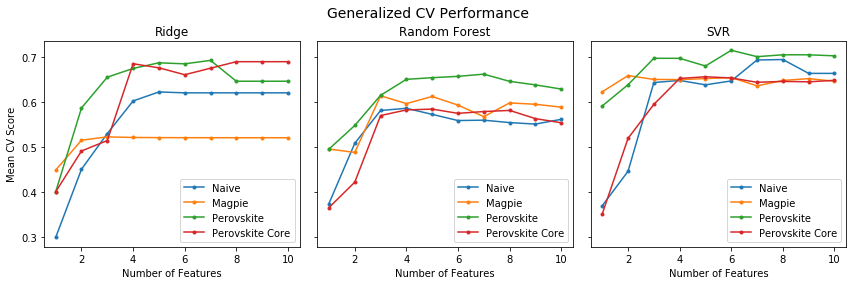

In [986]:
# plot repeated CV scores using general hyperparameters
fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)

for lib, ldict in libraries.items():
    nf = np.arange(1,11)
    scores = [ldict[f'ridge_gs_cv_score_{n}'] for n in nf]
    axes[0].plot(nf,scores,label=lib,marker='.')
    axes[0].set_title('Ridge')

for lib, ldict in libraries.items():
    nf = np.arange(1,11)
    scores = [ldict[f'rf_gs_cv_score_{n}'] for n in nf]
    axes[1].plot(nf,scores,label=lib,marker='.')
    axes[1].set_title('Random Forest')
    
for lib, ldict in libraries.items():
    nf = np.arange(1,11)
    scores = [ldict[f'svr_gs_cv_score_{n}'] for n in nf]
    axes[2].plot(nf,scores,label=lib,marker='.')
    axes[2].set_title('SVR')

for ax in axes:
    ax.legend()
    ax.set_xlabel('Number of Features')
    
axes[0].set_ylabel('Mean CV Score')
fig.tight_layout()
fig.suptitle('Generalized CV Performance',size=14)
fig.subplots_adjust(top=0.86)

The results are similar to those obtained previously for CV split 17, but much noisier, which is to be expected given the use of random CV splits. The CV scores obtained are also slightly lower than those obtained for CV split 17, as the hyperparameters used were not specifically optimized for the CV splits used in scoring.

We can now use the generally optimized hyperparameters to train models on the full train-test set and predict the holdout set. However, we must consider two aspects of predicting the holdout that differ from predicting a test fold in the train-test set. First, the training data set is 33% larger, since the full train-test set will be used to train before predicting the holdout. Secondly, and more importantly, the features selected by SFS were selected with full knowledge of the entire train-test set. This means that there is some influence of all train-test samples on the selected features, and that the model must inherently be overfit to the train-test set. Both of these factors would point us to adjust the hyperparameters to increase the regularization level relative to the values optimized by CV on the train-test set. For ridge regression, this would simply be increasing $\alpha$; for random forest, decreasing the number of estimators and/or reducing the maximum depth; and for SVR, decreasing the C parameter and increasing the $\gamma$ parameter.

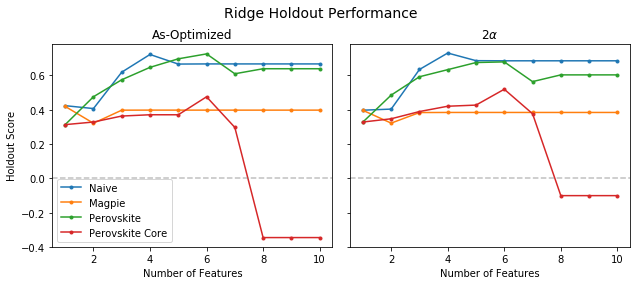

In [989]:
# Ridge holdout prediction
fig, axes = plt.subplots(1,2,figsize=(9,4),sharey=True)
for lib, ldict in libraries.items():
    nf = np.arange(1,11)
    scores = [ldict[f'ridge_gs_ho_score_{n}'] for n in nf]
    axes[0].plot(nf,scores,label=lib,marker='.')
    axes[0].set_title('As-Optimized')
    scores_adj = [ldict[f'ridge_gs_ho_score_2alpha_{n}'] for n in nf]
    axes[1].plot(nf,scores_adj,label=lib,marker='.')
    axes[1].set_title(r'$2\alpha$')
axes[0].legend()
axes[0].set_ylabel('Holdout Score')
for ax in axes:
    ax.set_xlabel('Number of Features')
    ax.axhline(0,c='gray',ls='--',alpha=0.5)
    
fig.tight_layout()
fig.suptitle('Ridge Holdout Performance',size=14)
fig.subplots_adjust(top=0.85)
    
#save_pickle(libraries,'tmp_lib')

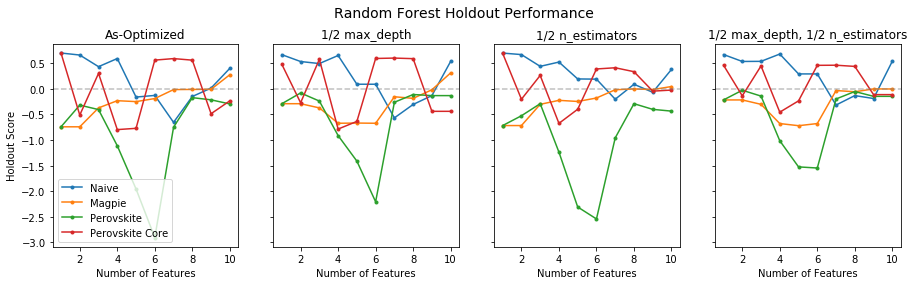

In [988]:
# RF holdout prediction
fig, axes = plt.subplots(1,4,figsize=(13,4),sharey=True)
for lib, ldict in libraries.items():
    nf = np.arange(1,11)
    scores = [ldict[f'rf_gs_ho_score_{n}'] for n in nf]
    axes[0].plot(nf,scores,label=lib,marker='.')
    axes[0].set_title('As-Optimized')
    scores_halfdepth = [ldict[f'rf_gs_ho_score_halfdepth_{n}'] for n in nf]
    axes[1].plot(nf,scores_halfdepth,label=lib,marker='.')
    axes[1].set_title('1/2 max_depth')
    scores_halfn = [ldict[f'rf_gs_ho_score_halfn_{n}'] for n in nf]
    axes[2].plot(nf,scores_halfn,label=lib,marker='.')
    axes[2].set_title('1/2 n_estimators')
    scores_adj = [ldict[f'rf_gs_ho_score_adj_{n}'] for n in nf]
    axes[3].plot(nf,scores_adj,label=lib,marker='.')
    axes[3].set_title('1/2 max_depth, 1/2 n_estimators')
    
axes[0].legend()
axes[0].set_ylabel('Holdout Score')
for ax in axes:
    ax.set_xlabel('Number of Features')
    ax.axhline(0,c='gray',ls='--',alpha=0.5)
    
fig.tight_layout()
fig.suptitle('Random Forest Holdout Performance',size=14)
fig.subplots_adjust(top=0.85)
    
#save_pickle(libraries,'tmp_lib')

perovksite core and naive probably do better with RF because they have fewest features

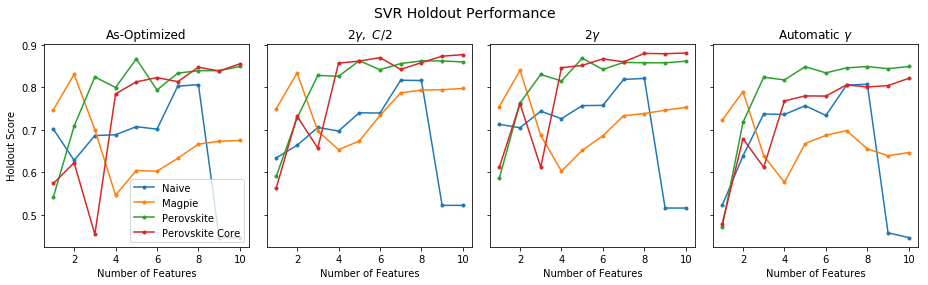

In [990]:
# SVR holdout prediction
fig, axes = plt.subplots(1,4,figsize=(13,4),sharey=True)
for lib, ldict in libraries.items():
    nf = np.arange(1,11)
    scores = [ldict[f'svr_gs_ho_score_{n}'] for n in nf]
    axes[0].plot(nf,scores,label=lib,marker='.')
    axes[0].set_title('As-Optimized')
    scores_adj = [ldict[f'svr_gs_ho_score_adj_{n}'] for n in nf]
    axes[1].plot(nf,scores_adj,label=lib,marker='.')
    axes[1].set_title('$2\gamma, \ C/2$')
    scores_2g = [ldict[f'svr_gs_ho_score_2gamma_{n}'] for n in nf]
    axes[2].plot(nf,scores_2g,label=lib,marker='.')
    axes[2].set_title('$2\gamma$')
    scores_autogamma = [ldict[f'svr_gs_ho_score_autogamma_{n}'] for n in nf]
    axes[3].plot(nf,scores_autogamma,label=lib,marker='.')
    axes[3].set_title('Automatic $\gamma$ ')
axes[0].legend()
axes[0].set_ylabel('Holdout Score')
for ax in axes:
    ax.set_xlabel('Number of Features')
    
fig.tight_layout()
fig.suptitle('SVR Holdout Performance',size=14)
fig.subplots_adjust(top=0.85)
    
#save_pickle(libraries,'tmp_lib')

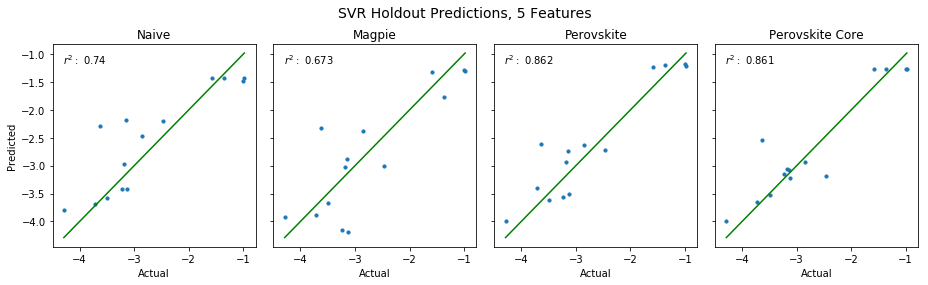

In [991]:
# Predict the holdout
fig, axes = plt.subplots(1,4,figsize=(13,4),sharex=True,sharey=True)

for (lib,ldict), ax in zip(libraries.items(),axes):
    est = copy.deepcopy(svp_for_gs)
    X_tt = ldict['X_tt'].loc[:, ldict['SFS_svr_subsets'][5]['feature_names']]
    X_ho = ldict['X_ho'].loc[:, ldict['SFS_svr_subsets'][5]['feature_names']]
    # adjust params for larger training set
    params = ldict['svr_gs_params_5']
    est.set_params(svr__C=params['svr__C']*0.5,svr__gamma=params['svr__gamma']*2)
    est.fit(X_tt,y_tt)
    #print(est.get_params()['svr__C'],est.get_params()['svr__gamma'])
    mv.plot_pva(est,X_ho,y_ho,ax=ax)
    ax.set_title(lib)
    
for ax in axes[1:]:
    ax.set_ylabel('')

fig.tight_layout()
fig.suptitle('SVR Holdout Predictions, 5 Features',size=14)
fig.subplots_adjust(top=0.85)

In [672]:
save_pickle(libraries,'tmp_lib')

Dumped pickle to tmp_lib


Quantiles : [0.         0.         0.         0.         0.         0.
 0.04853025 0.10087467 0.16622222 0.20018553 0.20618557]
Quantiles : [0.         0.         0.         0.         0.         0.
 0.         0.13959391 0.16666667 0.18367347 0.2020202 ]
Quantiles : [0.         0.         0.         0.         0.         0.
 0.         0.         0.18145455 0.18181818 0.2020202 ]
Quantiles : [0.5480226  0.55332092 0.56139513 0.58333333 0.58847476 0.59183673
 0.5959596  0.5959596  0.5959596  0.5959596  0.62264151]
Quantiles : [0.         0.         0.         0.         0.         0.
 0.         0.         0.04972129 0.08991767 0.2       ]
Quantiles : [1115.  1193.  1193.  1294.  1294.  1636.5 1814.  1814.  2128.  2128.
 2128. ]
Quantiles : [103.3        104.26493506 104.66802721 105.40808081 106.11453309
 107.56538462 110.03083667 112.80428305 115.17280672 116.98421053
 118.68686869]
Quantiles : [0.94968269 0.96034976 0.97395326 0.99475833 1.00024588 1.0087274
 1.0229603  1.07158212 1

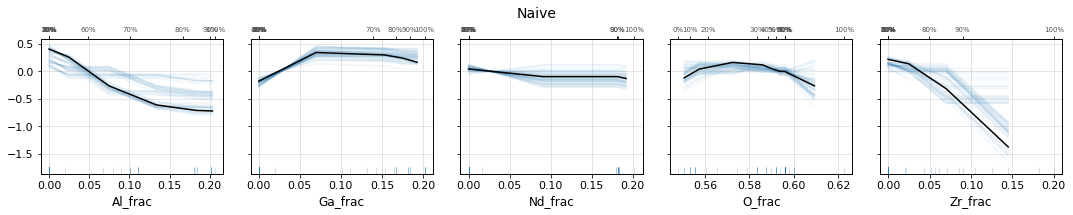

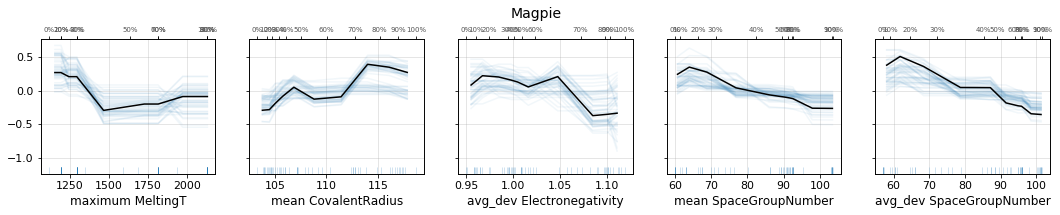

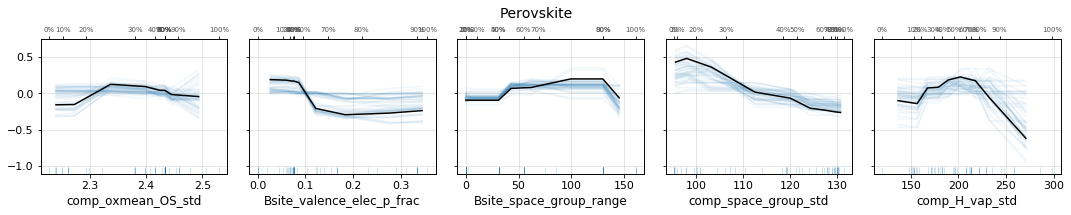

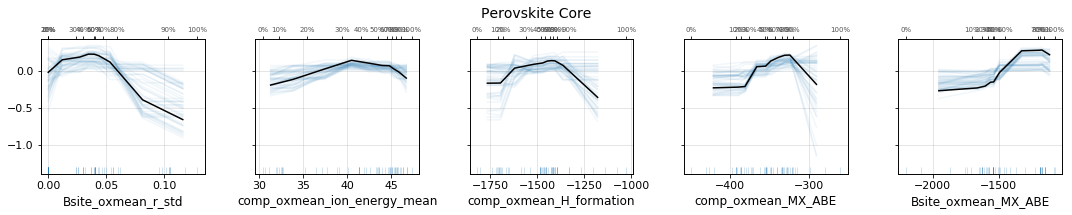

In [992]:
# examine ALE plots
for lib, ldict in libraries.items():
    cols = list(ldict['SFS_svr_subsets'][5]['feature_names'])
    X_tt = ldict['X_tt'].loc[:,cols]
    est = copy.deepcopy(svp_for_gs)
    # adjust params for larger training set
    params = ldict['svr_gs_params_5']
    est.set_params(svr__C=params['svr__C']*0.5,svr__gamma=params['svr__gamma']*2)
    est.fit(X_tt,y_tt)
    model_ale_plots(est,ldict['Xy_tt'],cols,ncol=5,subplot_dims=(3,3),monte_carlo=True,monte_carlo_rep=50,monte_carlo_ratio=0.2)
    plt.gcf().suptitle(lib,size=14)
    plt.gcf().subplots_adjust(top=0.83)

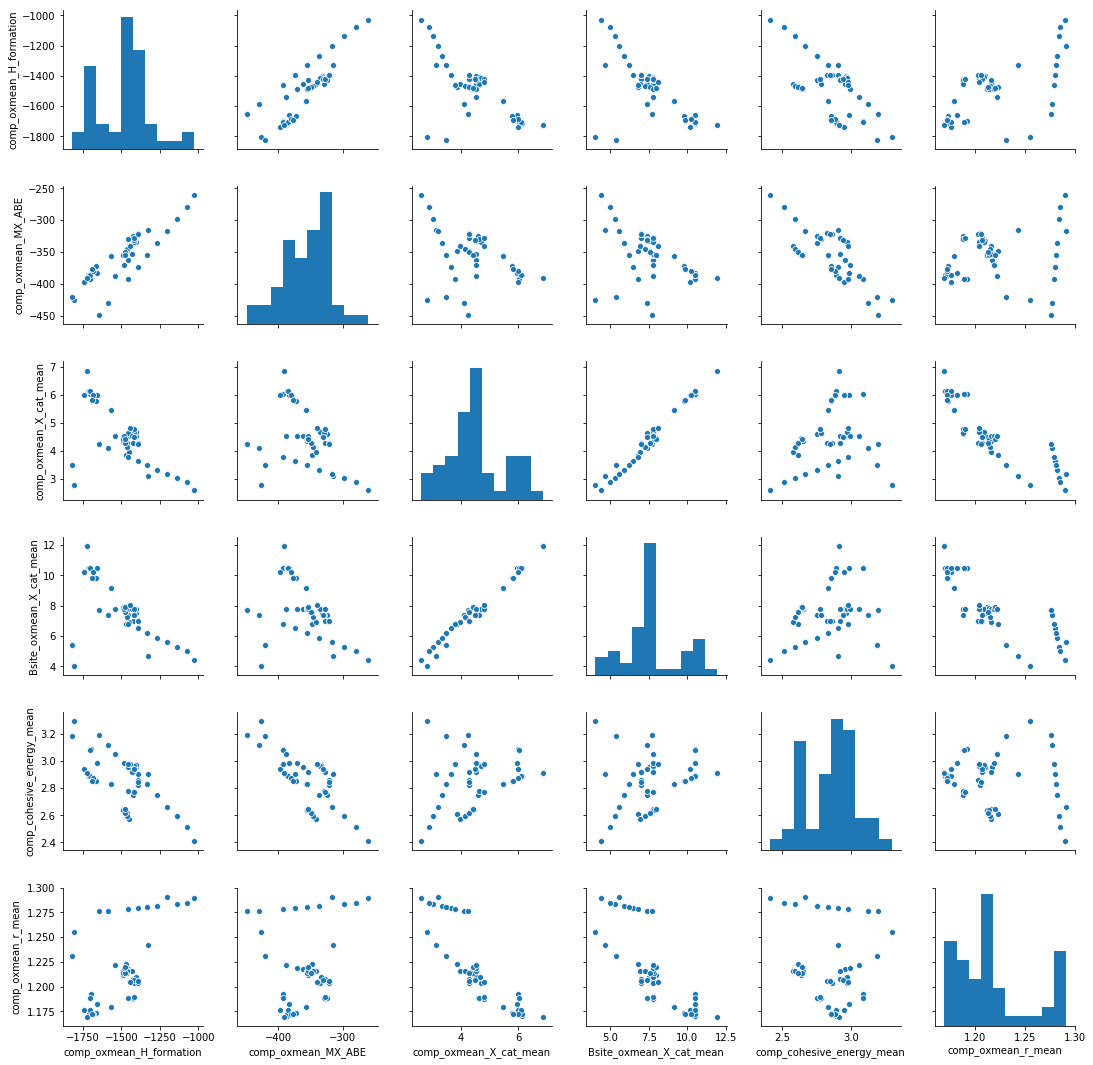

In [557]:
target_feat = 'comp_oxmean_H_formation' #'comp_oxmean_ion_energy_mean'
cf = rank_correlation(pcore_Xy_tt,target_feat)
sn.pairplot(pcore_Xy_tt, vars = [target_feat] + list(cf[:5]))

Bsite_oxmean_r_std: some mixing, ie doping, on B site beneficial - probably to create vacancies. Too much variation in radius bad for symmetry, cubic stability, mobility
comp_oxmean_ion_energy_mean: inversely related to anion_delta. Optimum indicates optimum anion_delta. Need enough O vacancies for vacancy diffusion, but too many vacancies probably destabilizes structure
comp_oxmean_H_formation: more negative Hf indicates stronger M-O bonding, stability; more positive indicates weaker bonding relative to M-M bonding. Optimum balances stability with O mobility
comp_oxmean_MX_ABE: optimum for composition-averaged M-O bond energy. Similar to H_formation
Bsite_oxmean_MX_ABE: weaker M-O bonds leads to greater O mobility


# repeat for remaining holdout folds

In [872]:
# get the indices used for the original train/test-validation split
ssp = ShuffleSplit(n_splits=5, test_size=0.2,random_state=121)
train_test_idx, holdout_idx = next(ssp.split(df['log_sigma']))
# the first train/test-validation split is the one we just worked through
df_ttv_index = [(train_test_idx,holdout_idx)] 
# verify that holdout_idx matches y_ho
y_match = len(holdout_idx)==np.sum(y_ho==df['log_sigma'].values[holdout_idx])

# split the train/test set into 4 sets to get the reminaing train/test-validation splits
kf = KFold(4,shuffle=True,random_state=121)
for train_idx, test_idx in kf.split(train_test_idx):
    # Get the indices for the KFold splits in terms of the original df 
    # Add the first holdout indices, since the first holdout will be in the train/test fold for all remaining folds
    df_train_idx = np.concatenate((train_test_idx[train_idx],holdout_idx))
    df_test_idx = train_test_idx[test_idx]
    df_ttv_index.append((df_train_idx,df_test_idx))
    
# verify splits
# verify no overlap in train/test folds
tt_overlap = reduce(np.intersect1d,([t for t,h in df_ttv_index]))
# verify no overlap in holdout folds
h_overlap = reduce(np.intersect1d,([h for t,h in df_ttv_index]))
# verify every sample appears once in holdout folds
h_concat = np.concatenate([h for t,h in df_ttv_index])
h_complete = len(df.index)==np.sum(sorted(h_concat)==df.index.values)
# verify each fold contains all samples
ttv_concat = [sorted(np.concatenate((t,h))) for t,h in df_ttv_index]
splits_complete = np.min([len(df.index)==np.sum(ttv==df.index.values) for ttv in ttv_concat])

if y_match and len(tt_overlap) + len(h_overlap)==0 and h_complete and splits_complete:
    print('Splits are valid')
else:
    raise Exception('Splits are invalid')

Splits are valid


In [995]:
sfs_svr.set_params(verbose=0)
results_list = []
for split, (tt_idx, ho_idx) in enumerate(df_ttv_index):
    
    for lib, ldict in libraries.items():
        X_tt = ldict['X'].loc[tt_idx,:]
        X_ho = ldict['X'].loc[ho_idx,:]
        
        #ldict['holdout_results'] = {} # {split_number:{sfs_svr_subsets,}}
        print(f'Split {split},',lib)
        if split==0:
            # same holdout tested above - use previously determined subsets
            subsets = ldict['SFS_svr_subsets']
        else:
            sfs_svr.fit(X_tt.values,y[tt_idx],custom_feature_names=X_tt.columns)
            subsets = sfs_svr.subsets_
        tmp_results = pd.DataFrame.from_dict(subsets,orient='index')
        tmp_results['n_feat'] = tmp_results.index
        tmp_results['split_num'] = split
        tmp_results['library'] = lib
        
        # optimize hyperparams, train, and predict holdout for 1-10 features
        svr_for_gs = SVR()  
        svp_for_gs = Pipeline([('scale',ss),('svr',svr_for_gs)])

        opt_params = []
        cv_scores = []
        holdout_scores = []
        for n in range(1,11):
            print(f'{n} features')
            cols = subsets[n]['feature_names']
            X_tt_n = X_tt.loc[:,cols]
            X_ho_n = X_ho.loc[:,cols]

            # optimize for general CV on training set
            gs_params = []
            for seed in [3,11,37,6,89]:
                gs = GridSearchCV(svp_for_gs,cv=KFold(4,shuffle=True,random_state=seed),
                          param_grid={'svr__C':np.logspace(-1,1,10),'svr__gamma':list(np.logspace(-1,1,10))})
                # GridSearch hyperparameters depend significantly on random split
                # Repeat GridSearch for more stable hyperparameters
                gs.fit(X_tt_n,y[tt_idx])
                gs_params.append(gs.best_params_)
            C_vals = [gd['svr__C'] for gd in gs_params]
            C = np.min(C_vals) #choose min C to be conservative
            gamma_vals = [gd['svr__gamma'] for gd in gs_params]
            gamma = np.median(gamma_vals) #choose median gamma
            opt_params.append({'svr__C':C,'svr__gamma':gamma})

            # CV on train/test set with optimized params
            est = gs.best_estimator_
            est.set_params(svr__C=C,svr__gamma=gamma)
            act,pred, scores = mv.repeated_KFold_cv(est,X_tt_n,y[tt_idx],repeat=10,k=4,random_state=23)
            cv_scores.append(np.mean(scores))

            # adjust C and gamma for larger training set
            est.set_params(svr__C=C*0.5,svr__gamma=gamma*2)
            est.fit(X_tt_n,y[tt_idx])
            holdout_scores.append(est.score(X_ho_n,y[ho_idx]))
            
        tmp_results['opt_params'] = opt_params
        tmp_results['opt_cv_score_mean'] = cv_scores
        tmp_results['holdout_score'] = holdout_scores
        results_list.append(tmp_results)


Split 0, Naive
1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
Split 0, Magpie
1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
Split 0, Perovskite
1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
Split 0, Perovskite Core
1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
Split 1, Naive
1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
Split 1, Magpie
1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
Split 1, Perovskite
1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
Split 1, Perovskite Core
1 features
2 features
3 features
4 features
5 features
6 features
7 fea

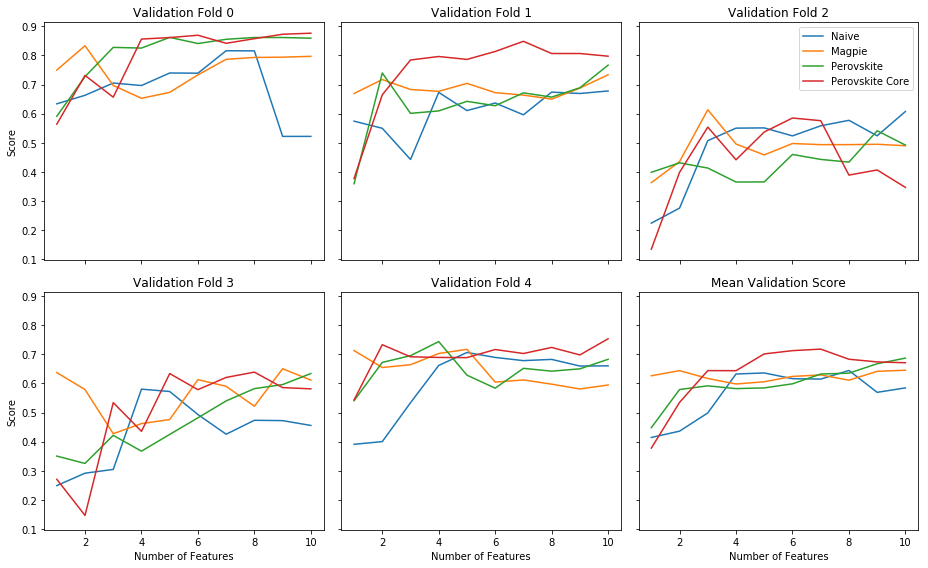

In [1030]:
fig, axes = plt.subplots(2,3,figsize=(13,8),sharex=True,sharey=True)
# default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# lib_color = dict(zip(libraries.keys(),default_colors))
for (split,sdf), ax in zip(holdout_results.groupby('split_num'),axes.ravel()):
    for lib in libraries.keys():
        ldf = sdf[sdf['library']==lib]
        ax.plot(ldf['n_feat'],ldf['holdout_score'],label=lib)
        ax.set_title(f'Validation Fold {split}')

# for (lib,split), gdf in holdout_results.groupby(['library','split_num']):
#     ax = axes.ravel()[split]
#     ax.plot(gdf['n_feat'],gdf['holdout_score'],label=lib,c=lib_color[lib])
#     ax.set_title(f'Validation Fold {split}')

for lib in libraries.keys():
    ldf = holdout_results[holdout_results['library']==lib]
    gdf = ldf.groupby('n_feat').mean()
    axes[1,2].plot(gdf.index,gdf['holdout_score'],label=lib)
axes[1,2].set_title('Mean Validation Score')

for ax in axes[1,:]:
    ax.set_xlabel('Number of Features')
for ax in axes[:,0]:
    ax.set_ylabel('Score')


axes[0,2].legend()
# h,l = axes[1,2].get_legend_handles_labels()
# fig.legend(handles=h,labels=l,loc='upper left',bbox_to_anchor=(0.9,0.96))
fig.tight_layout()
# fig.subplots_adjust(right=0.9)

In [1095]:
holdout_results[holdout_results['library']=='Perovskite Core']

,feature_idx,cv_scores,avg_score,feature_names,n_feat,split_num,library,opt_params,opt_cv_score_mean,holdout_score
30,"(40,)","[0.2807240692803201, 0.4968159733455836, 0.374...",0.404741,"(Bsite_oxmean_MX_ABE,)",1,0,Perovskite Core,"{'svr__C': 0.46415888336127786, 'svr__gamma': ...",0.350744,0.563955
31,"(35, 40)","[0.54274832583754, 0.6818782104254493, 0.53289...",0.589511,"(comp_oxmean_ion_energy_mean, Bsite_oxmean_MX_...",2,0,Perovskite Core,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.519022,0.731602
32,"(20, 35, 40)","[0.779108483820938, 0.6669035534917588, 0.5159...",0.658324,"(Bsite_oxmean_r_std, comp_oxmean_ion_energy_me...",3,0,Perovskite Core,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.594660,0.656703
33,"(20, 35, 37, 40)","[0.6767883147346865, 0.7559675519037132, 0.692...",0.691765,"(Bsite_oxmean_r_std, comp_oxmean_ion_energy_me...",4,0,Perovskite Core,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.652372,0.856372
34,"(20, 35, 37, 38, 40)","[0.6863182371587905, 0.7529808350190491, 0.695...",0.691191,"(Bsite_oxmean_r_std, comp_oxmean_ion_energy_me...",5,0,Perovskite Core,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.656149,0.861450
35,"(20, 35, 37, 38, 39, 40)","[0.6799728010807953, 0.7462973000930497, 0.682...",0.689629,"(Bsite_oxmean_r_std, comp_oxmean_ion_energy_me...",6,0,Perovskite Core,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.653469,0.869459
36,"(20, 35, 37, 38, 39, 40, 58)","[0.7053839635095874, 0.7489812328879797, 0.670...",0.693787,"(Bsite_oxmean_r_std, comp_oxmean_ion_energy_me...",7,0,Perovskite Core,"{'svr__C': 0.774263682681127, 'svr__gamma': 0....",0.643796,0.841830
37,"(20, 35, 37, 38, 39, 40, 50, 58)","[0.695092847137575, 0.7439867741021663, 0.6623...",0.688642,"(Bsite_oxmean_r_std, comp_oxmean_ion_energy_me...",8,0,Perovskite Core,"{'svr__C': 0.774263682681127, 'svr__gamma': 0....",0.645793,0.857685
38,"(20, 26, 35, 37, 38, 39, 40, 50, 58)","[0.6558727667487483, 0.748302093820068, 0.6606...",0.687137,"(Bsite_oxmean_r_std, Bsite_oxmean_ion_energy_m...",9,0,Perovskite Core,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.644861,0.872925
39,"(20, 26, 35, 37, 38, 39, 40, 50, 51, 58)","[0.6601097985047711, 0.7497162548647097, 0.657...",0.687924,"(Bsite_oxmean_r_std, Bsite_oxmean_ion_energy_m...",10,0,Perovskite Core,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.648208,0.876494


# LOCO-CV

In [1090]:
amt_df = nv_df.drop(['composition','log_sigma'],axis=1)
sig_cols = amt_df.columns[amt_df.max()>0.15]
sig_cols

Index(['Al_frac', 'Ba_frac', 'Ga_frac', 'In_frac', 'La_frac', 'Lu_frac',
       'Nd_frac', 'O_frac', 'Sc_frac', 'Sr_frac', 'Ti_frac', 'Zr_frac'],
      dtype='object')

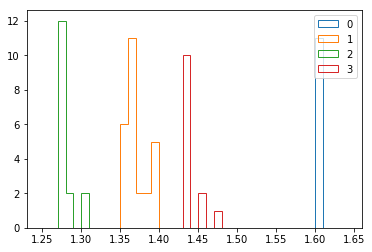

In [1097]:
db = DBSCAN(eps=0.2,min_samples=5)

dbp = Pipeline([('scale',ss),('cluster',db)])

dbdf = pcore_Xy.copy()
dbdf['cluster'] = dbp.fit_predict(pcore_Xy['Asite_oxmean_r_mean'].values.reshape(-1,1))
clusters = dbdf['cluster']


# clusters = db.fit_predict(amt_df.loc[:,sig_cols])

fig, ax = plt.subplots()
bins = np.arange(1.25,1.65,0.01)
for cluster in np.unique(clusters):
    idx = np.where(clusters==cluster)[0]
    cdf = pk_df.iloc[idx,:]
    ax.hist(cdf['Asite_oxmean_r_mean'],bins=bins,label=cluster,histtype='step')
    
ax.legend()

# fig, ax = plt.subplots()

# for cluster in np.unique(clusters):
#     idx = np.where(clusters==cluster)[0]
#     cdf = pk_df.iloc[idx,:]
#     ax.scatter(cdf['Asite_oxmean_r_mean'],cdf['Bsite_oxmean_r_mean'],label=cluster)


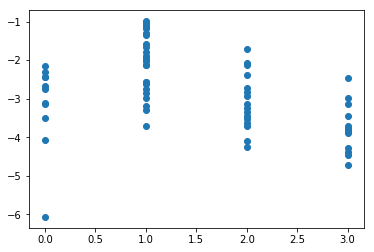

In [1098]:
plt.scatter(clusters,y)

In [1105]:
holdout_results

,feature_idx,cv_scores,avg_score,feature_names,n_feat,split_num,library,opt_params,opt_cv_score_mean,holdout_score
0,"(4,)","[0.07191974313242677, 0.3878434245239111, 0.49...",0.355786,"(Ga_frac,)",1,0,Naive,"{'svr__C': 0.2782559402207124, 'svr__gamma': 5...",0.368931,0.633824
1,"(4, 21)","[0.18609430232186097, 0.6323530340452886, 0.54...",0.485773,"(Ga_frac, Zr_frac)",2,0,Naive,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.445669,0.663152
2,"(0, 4, 21)","[0.34476680586761843, 0.7355395453658232, 0.80...",0.626282,"(Al_frac, Ga_frac, Zr_frac)",3,0,Naive,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.643298,0.705285
3,"(0, 4, 12, 21)","[0.41638358738704007, 0.7510411691429983, 0.75...",0.646237,"(Al_frac, Ga_frac, O_frac, Zr_frac)",4,0,Naive,"{'svr__C': 1.291549665014884, 'svr__gamma': 0....",0.647988,0.696736
4,"(0, 4, 10, 12, 21)","[0.3825000769247212, 0.7920294829961974, 0.782...",0.653619,"(Al_frac, Ga_frac, Nd_frac, O_frac, Zr_frac)",5,0,Naive,"{'svr__C': 1.291549665014884, 'svr__gamma': 0.1}",0.638159,0.739797
5,"(0, 4, 10, 12, 14, 21)","[0.40040773352929837, 0.7809908759641014, 0.77...",0.664638,"(Al_frac, Ga_frac, Nd_frac, O_frac, Si_frac, Z...",6,0,Naive,"{'svr__C': 1.291549665014884, 'svr__gamma': 0.1}",0.646873,0.739108
6,"(0, 4, 10, 12, 14, 16, 21)","[0.3896102373389497, 0.8099756696945117, 0.735...",0.659270,"(Al_frac, Ga_frac, Nd_frac, O_frac, Si_frac, S...",7,0,Naive,"{'svr__C': 2.1544346900318834, 'svr__gamma': 0...",0.693508,0.816312
7,"(0, 4, 8, 10, 12, 14, 16, 21)","[0.3794944900636229, 0.7983970017347787, 0.764...",0.655920,"(Al_frac, Ga_frac, Lu_frac, Nd_frac, O_frac, S...",8,0,Naive,"{'svr__C': 2.1544346900318834, 'svr__gamma': 0...",0.694519,0.815717
8,"(0, 4, 8, 10, 12, 14, 16, 18, 21)","[0.35209584189710985, 0.8084735881114725, 0.76...",0.650039,"(Al_frac, Ga_frac, Lu_frac, Nd_frac, O_frac, S...",9,0,Naive,"{'svr__C': 2.1544346900318834, 'svr__gamma': 0.1}",0.663655,0.522006
9,"(0, 2, 4, 8, 10, 12, 14, 16, 18, 21)","[0.34330484417030904, 0.8087791351262046, 0.77...",0.648141,"(Al_frac, Be_frac, Ga_frac, Lu_frac, Nd_frac, ...",10,0,Naive,"{'svr__C': 2.1544346900318834, 'svr__gamma': 0.1}",0.663655,0.522006


In [1106]:
def single_cluster_val_with_selection(sfs,estimator,X,y,clusters,test_cluster,random_state=None,
                                      gridsearchCV_repeat=5,param_grid={},param_agg={},param_factor={}):
    """
    Predict a single test cluster using remaining clusters for training and feature selection (runs a single fold of LOCO-CV)
    Feature selection is performed using mlxtend SequentialFeatureSelector

    Args:
        cv_estimator: sklearn estimator instance to use for training and predicting response
        select_estimator: sklearn estimator instance to use for feature selection
        X: data matrix (nxm). numpy array or pandas dataframe
        y: response (n-vector)
        clusters: list of cluster labels for observations (n-vector)
        test_cluster: cluster to use as test set
        k_features: number of features to select
        selector_cv: int, sklearn splitter instance (e.g. KFold()), or LeaveOneClusterOut class for feature selection cross validation.
        standardize: if True, standardize inputs (center and whiten)
        selector_params: keywords for SequentialFeatureSelector

    Returns: 
        train_scores: training set scores 
        test_scores: test set scores
        test_pred: test set predicted values
        test_act: test set actual values
        train_pred: test set predicted values 
        train_act: train set predicted values
        selected_features: selected features
    """

    if type(X)==pd.core.frame.DataFrame:
        X_df = X
        X = X.values
        X_is_df=True
    else:
        X_is_df=False

    train_idx = np.where(clusters!=test_cluster)
    test_idx = np.where(clusters==test_cluster)
    X_train = X[train_idx]
    y_train = y[train_idx]

    #select features based on training data
    if X_is_df:
        sfs.fit(X_train,y_train,custom_feature_names=X_df.columns.values)
    else:
        sfs.fit(X_train,y_train)
        
    results = pd.DataFrame.from_dict(sfs.subsets_,orient='index')

    #train model on training data with selected features only, for 1-k features
    opt_params = []
    cv_mean_scores = []
    test_scores = []
    for n_feat, subset in sfs.subsets_.items():
        print(n_feat)
        if X_is_df:
            selected_features = list(subset['feature_names'])
            X_select = X_df.loc[:,selected_features].values
        else:
            selected_features = list(subset['feature_idx'])
            X_select = X[:,selected_features]
    
        X_train_sel = X_select[train_idx]        
        rand = np.random.RandomState(random_state)
        seeds = rand.randint(0,100,gridsearchCV_repeat)
        gs_params = []
        for seed in seeds:
            gs = GridSearchCV(estimator,cv=KFold(4,shuffle=True,random_state=seed),
                              param_grid=param_grid)
            gs.fit(X_train_sel,y_train)
            gs_params.append(gs.best_params_)
        # aggregate optimized params as specified. Use median by default
        agg_params = {param_name:getattr(np,param_agg.get(param_name,'median'))([gsp[param_name] for gsp in gs_params]) for param_name in param_grid.keys()}
        # multiply by specified factors
        final_params = {k:v*param_factor.get(k,1) for k,v in agg_params.items()}
        opt_params.append(final_params)

        # set params, cross-validate, and train
        estimator.set_params(**final_params)
        act,pred,scores = mv.repeated_KFold_cv(estimator,X_train_sel,y_train,repeat=10,k=4,random_state=random_state)
        cv_mean_scores.append(np.mean(scores))
        estimator.fit(X_train_sel,y_train)

        #predict test set with selected features
        X_test_sel = X_select[test_idx]
        y_test = y[test_idx]
        test_scores.append(estimator.score(X_test_sel,y_test))
        
    results['opt_params'] = opt_params
    results['opt_cv_score_mean'] = cv_mean_scores
    results['loco_score'] = test_scores

    return results

In [1103]:
x = [1,2,3]
getattr(np,'min')(x)

1

In [1132]:
sfs_ridge_loco = SFS(rrp_for_selection,
          k_features=10,
          forward=True,
          floating=False,
          verbose=0,
          scoring='r2',
          cv=KFold(4,shuffle=True,random_state=17),
          n_jobs=4)



loco_ridge = Ridge()
loco_rrp = Pipeline([('scale',ss),('ridge',loco_ridge)])
gs_kw = dict(param_grid = {'ridge__alpha':np.logspace(-2,2,20)})#,
#             param_agg = {'svr__alpha':'max'},
#             param_factor = {'svr__alpha':2})

results = single_cluster_val_with_selection(sfs_ridge_loco,loco_rrp,pcore_X,y,clusters,test_cluster=2,random_state=23,
                                      gridsearchCV_repeat=5,**gs_kw)

results

1
2
3
4
5
6
7
8
9
10


,feature_idx,cv_scores,avg_score,feature_names,opt_params,opt_cv_score_mean,loco_score
1,"(58,)","[0.3279238836719698, 0.291508710655062, 0.7293...",0.416843,"(Bsite_MX_IC_mean,)",{'ridge__alpha': 3.359818286283781},0.346879,-0.796486
2,"(27, 58)","[0.3975271131862733, 0.4067541892132225, 0.768...",0.508741,"(Bsite_oxmean_ion_energy_std, Bsite_MX_IC_mean)",{'ridge__alpha': 5.455594781168514},0.426488,-0.480847
3,"(27, 58, 68)","[0.6267276761840854, 0.2129849215881836, 0.935...",0.653598,"(Bsite_oxmean_ion_energy_std, Bsite_MX_IC_mean...",{'ridge__alpha': 3.359818286283781},0.680789,-0.756923
4,"(7, 27, 58, 68)","[0.6242481807763509, 0.4341570944566062, 0.924...",0.722696,"(comp_oxmean_uc_vol_free, Bsite_oxmean_ion_ene...",{'ridge__alpha': 3.359818286283781},0.687159,-0.270097
5,"(7, 20, 27, 58, 68)","[0.6481064729778261, 0.4828274903391584, 0.912...",0.739979,"(comp_oxmean_uc_vol_free, Bsite_oxmean_r_std, ...",{'ridge__alpha': 5.455594781168514},0.698098,-0.279677
6,"(7, 20, 27, 52, 58, 68)","[0.6886687259343087, 0.4901265847132512, 0.914...",0.750670,"(comp_oxmean_uc_vol_free, Bsite_oxmean_r_std, ...",{'ridge__alpha': 3.359818286283781},0.691178,-0.516530
7,"(7, 20, 27, 50, 52, 58, 68)","[0.6886687259343082, 0.49431946934518656, 0.92...",0.752977,"(comp_oxmean_uc_vol_free, Bsite_oxmean_r_std, ...",{'ridge__alpha': 3.359818286283781},0.689233,-0.464129
8,"(7, 20, 27, 50, 52, 58, 67, 68)","[0.6886687259343084, 0.49431989039598456, 0.92...",0.752978,"(comp_oxmean_uc_vol_free, Bsite_oxmean_r_std, ...",{'ridge__alpha': 3.359818286283781},0.689090,-0.462306
9,"(7, 20, 27, 41, 50, 52, 58, 67, 68)","[0.6886687259343078, 0.49431989039598545, 0.92...",0.752978,"(comp_oxmean_uc_vol_free, Bsite_oxmean_r_std, ...",{'ridge__alpha': 3.359818286283781},0.689090,-0.462306
10,"(7, 20, 27, 41, 45, 50, 52, 58, 67, 68)","[0.6886687259343083, 0.494319890395985, 0.9234...",0.752978,"(comp_oxmean_uc_vol_free, Bsite_oxmean_r_std, ...",{'ridge__alpha': 3.359818286283781},0.689090,-0.462306


In [1127]:
sfs_svr_loco = SFS(svp_for_selection,
          k_features=10,
          forward=True,
          floating=False,
          verbose=0,
          scoring='r2',
          cv=KFold(4,shuffle=True,random_state=17),
          n_jobs=4)



loco_svr = SVR()
loco_svp = Pipeline([('scale',ss),('svr',loco_svr)])
gs_kw = dict(param_grid = {'svr__C':np.logspace(-1,1,10),'svr__gamma':list(np.logspace(-1,1,10))})#,
#             param_agg = {'svr__C':'min','svr_gamma':'max'},
#             param_factor = {'svr__C':0.5,'svr_gamma':2})

results = single_cluster_val_with_selection(sfs_svr_loco,loco_svp,pk_X,y,clusters,test_cluster=2,random_state=23,
                                      gridsearchCV_repeat=5,**gs_kw)

results

1
2
3
4
5
6
7
8
9
10


,feature_idx,cv_scores,avg_score,feature_names,opt_params,opt_cv_score_mean,loco_score
1,"(239,)","[0.4417741744201902, 0.024648214506541866, 0.7...",0.504406,"(comp_space_group_std,)","{'svr__C': 2.1544346900318834, 'svr__gamma': 2...",0.635733,0.100556
2,"(24, 239)","[0.6631695254803753, 0.5235338112689376, 0.922...",0.751559,"(Bsite_oxmean_X_cat_mean, comp_space_group_std)","{'svr__C': 3.593813663804626, 'svr__gamma': 0....",0.791983,-0.230522
3,"(24, 37, 239)","[0.5383153782489074, 0.7017831105057477, 0.911...",0.755656,"(Bsite_oxmean_X_cat_mean, comp_oxmean_H_format...","{'svr__C': 3.593813663804626, 'svr__gamma': 0....",0.742423,-0.181626
4,"(24, 37, 188, 239)","[0.5624707716585592, 0.6942776799206927, 0.938...",0.772533,"(Bsite_oxmean_X_cat_mean, comp_oxmean_H_format...","{'svr__C': 2.1544346900318834, 'svr__gamma': 0...",0.760710,-0.319387
5,"(24, 37, 188, 239, 246)","[0.5973359024640857, 0.6743450832297834, 0.918...",0.784063,"(Bsite_oxmean_X_cat_mean, comp_oxmean_H_format...","{'svr__C': 2.1544346900318834, 'svr__gamma': 0...",0.807711,-0.125694
6,"(24, 33, 37, 188, 239, 246)","[0.6394165331600186, 0.6602196775393598, 0.953...",0.799701,"(Bsite_oxmean_X_cat_mean, comp_oxmean_X_cat_me...","{'svr__C': 2.1544346900318834, 'svr__gamma': 0...",0.816982,-0.163183
7,"(2, 24, 33, 37, 188, 239, 246)","[0.636402823433262, 0.650581075933696, 0.96370...",0.801639,"(comp_oxmean_tau, Bsite_oxmean_X_cat_mean, com...","{'svr__C': 5.994842503189409, 'svr__gamma': 0....",0.828246,-0.141469
8,"(2, 24, 33, 34, 37, 188, 239, 246)","[0.6320903726917101, 0.6513049098183581, 0.956...",0.797903,"(comp_oxmean_tau, Bsite_oxmean_X_cat_mean, com...","{'svr__C': 3.593813663804626, 'svr__gamma': 0....",0.829817,-0.158686
9,"(2, 22, 24, 33, 34, 37, 188, 239, 246)","[0.668018322014743, 0.61246641000196, 0.949222...",0.795225,"(comp_oxmean_tau, Bsite_oxmean_OS_std, Bsite_o...","{'svr__C': 3.593813663804626, 'svr__gamma': 0....",0.821021,-0.163139
10,"(2, 22, 24, 33, 34, 37, 142, 188, 239, 246)","[0.6712808240723305, 0.5876383421516977, 0.962...",0.795166,"(comp_oxmean_tau, Bsite_oxmean_OS_std, Bsite_o...","{'svr__C': 5.994842503189409, 'svr__gamma': 0.1}",0.822454,-0.043911


In [1129]:
pk_res = results

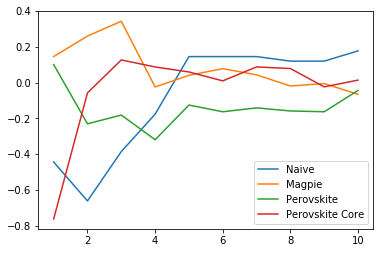

In [1130]:
plt.plot(nv_res.index,nv_res['loco_score'],label='Naive')
plt.plot(ep_res.index,ep_res['loco_score'],label='Magpie')
plt.plot(pk_res.index,pk_res['loco_score'],label='Perovskite')
plt.plot(pcore_res.index,pcore_res['loco_score'],label='Perovskite Core')

plt.legend()

# LOCO-CV classification

# End

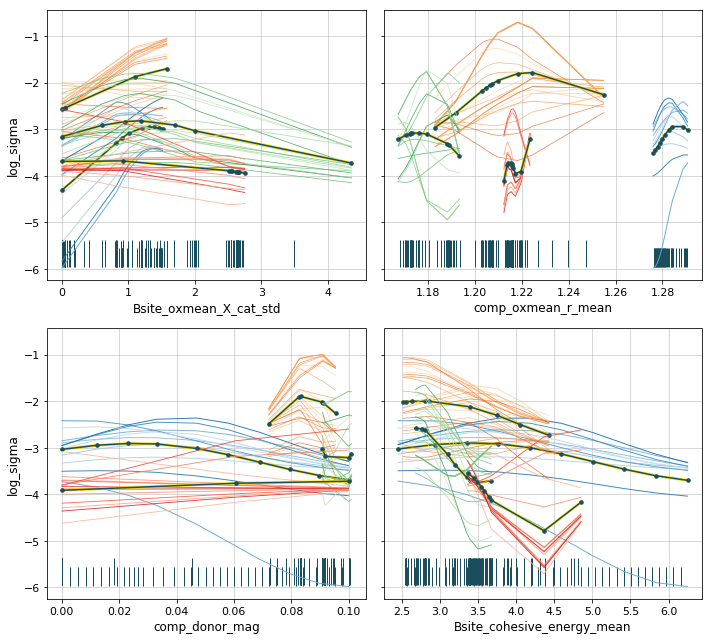

In [162]:
# split pdp plots by major A-site element
ldict = libraries['Perovskite Core']
cols = list(ldict['SFS_svr_subsets'][4]['feature_names'])


db = DBSCAN(eps=0.3,min_samples=5)
dbp = Pipeline([('scale',ss),('cluster',db)])

dbdf = pcore_Xy.copy()
dbdf['cluster'] = dbp.fit_predict(pcore_Xy['Asite_oxmean_r_mean'].values.reshape(-1,1))

ice_cmaps = ['Blues','Oranges','Greens','Reds']

for (cluster, cdf), ice_cmap in zip(dbdf.groupby('cluster'),ice_cmaps):
    X = cdf.loc[:,cols]
    cy = cdf['log_sigma']
    ldict['svr_gs_5'].fit(X,cy)
    if cluster==0:
        axes = model_iso_plots(ldict['svr_gs_5'],cdf,cols,ncol=2,plot_dist=True,plot_lines=True,
                    plot_pts=False,response_col='log_sigma',center=False,ice_cmap=ice_cmap)
    else: 
        model_iso_plots(ldict['svr_gs_5'],cdf,cols,ncol=2,plot_dist=True,plot_lines=True,
                    plot_pts=False,response_col='log_sigma',center=False,axes=axes,ice_cmap=ice_cmap)

## Clustered Regressor

## C. Additional feature correlations and pairplots

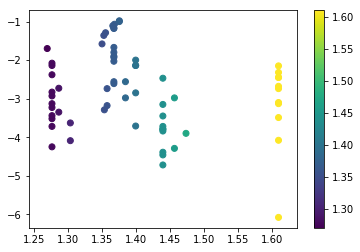

In [37]:
p = plt.scatter(pcore_Xy['Asite_oxmean_r_mean'],pcore_Xy['log_sigma'],c=pcore_Xy['Asite_oxmean_r_mean'])
plt.colorbar(p)

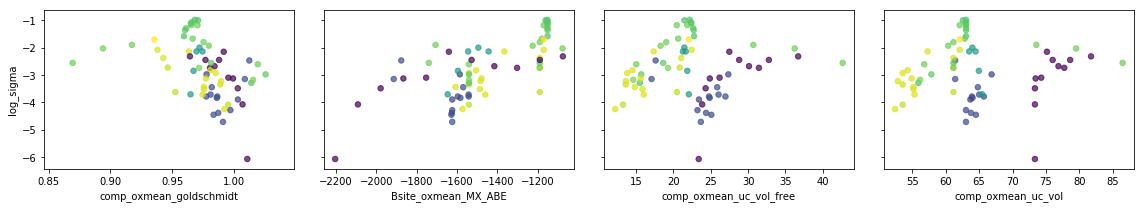

In [40]:
xy_pairplots(pcore_Xy,'log_sigma',c_col='Asite_X_mean', subplot_size=(4,3),
             xvars=['comp_oxmean_goldschmidt','Bsite_oxmean_MX_ABE','comp_oxmean_uc_vol_free','comp_oxmean_uc_vol'],
             alpha=0.7,s=30)

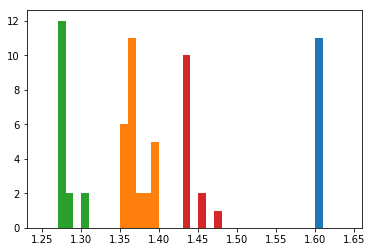

In [ ]:
cdf

In [ ]:
cluster_cols = {}
cluster_act = {}
cluster_pred = {}
for cluster, cdf in dbdf.groupby('cluster'):
    print(f'Cluster {cluster}')
    
    cX = cdf.drop(['cluster','log_sigma'],axis=1)
    cy = cdf['log_sigma']
    
    sfs_cluster = SFS(svp_for_selection,
          k_features=10,
          forward=True,
          floating=True,
          verbose=1,
          scoring='r2',
          cv=KFold(4,shuffle=True,random_state=17),
          n_jobs=1)
    
    sfs_cluster.fit(cX.values,cy,custom_feature_names=cX.columns)
    cols = sfs_cluster.subsets_[10]['feature_names']
    
    svr_for_gs = SVR()  
    svp_for_gs = Pipeline([('scale',ss),('svr',svr_for_gs)])
    gs = GridSearchCV(svp_for_gs,cv=KFold(4,shuffle=True,random_state=17),
                      param_grid={'svr__C':np.logspace(-1,3,10)})#,'svr__gamma':np.logspace(-2,2,5)})
    
#     rf_for_gs = RandomForestRegressor()
#     rfp_for_gs = Pipeline([('scale',ss),('rf',rf_for_gs)])
#     gs = GridSearchCV(rfp_for_gs,
#                           param_grid={'rf__n_estimators':[5,10,20,50],'rf__min_samples_leaf':[1,2,3,4],'rf__min_samples_split':[2,4,6,8]}
#                          )
    
    gs.fit(cX.loc[:,cols],cy)
    print(cluster, gs.best_params_, gs.best_score_)
    est = gs.best_estimator_
    
    act, pred, train_scores, test_scores = mv.KFold_cv(est,cX.loc[:,cols],cy)
    cluster_cols[cluster] = cols
    cluster_act[cluster] = act
    cluster_pred[cluster] = pred
    
fig, ax = plt.subplots()
for cluster, actual in cluster_act.items():
    predicted = cluster_pred[cluster]
    
    ax.scatter(actual,predicted,label=cluster)
    
ax.legend()

r_squared(np.concatenate(list(cluster_act.values())),np.concatenate(list(cluster_pred.values())))